# Time Series Data Forecasting

#### Setup

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pprint

## Microsoft Stock Closing Price Data (2019 to 2024)

In [3]:
df = yf.download("MSFT", start="2019-01-01", end="2024-12-31")
df = df[['Close']].rename(columns={'Close': 'price'})
df.dropna(inplace=True)
df.head()

/tmp/ipython-input-3-2809912734.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("MSFT", start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price           price
Ticker           MSFT
Date                 
2019-01-02  94.945518
2019-01-03  91.452652
2019-01-04  95.706070
2019-01-07  95.828102
2019-01-08  96.522942

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2019-01-02 to 2024-12-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (price, MSFT)  1509 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [5]:
df.columns

MultiIndex([('price', 'MSFT')],
           names=['Price', 'Ticker'])

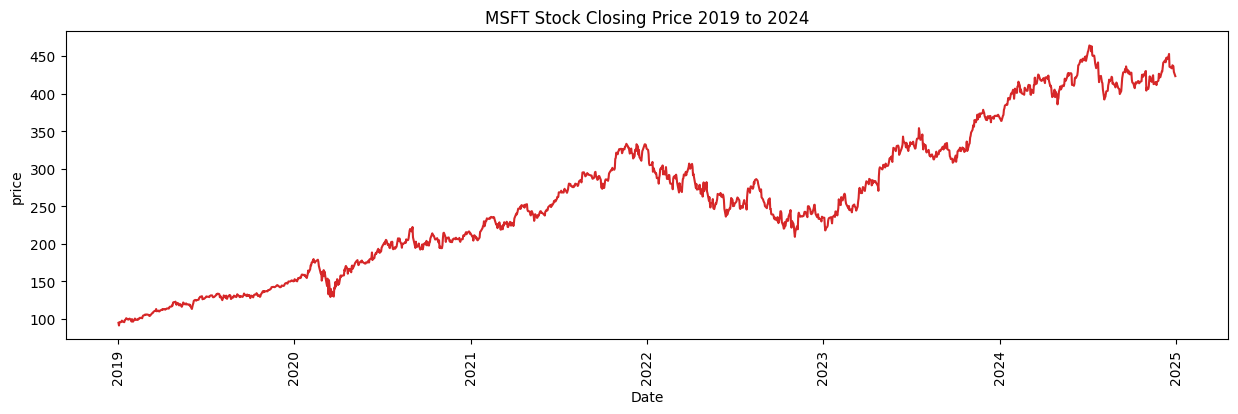

In [6]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='price', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    # ax.set_xticks(ax.get_xticks()[::2])
    plt.xticks(rotation=90)
    plt.show()


plot_df(df, x=df.index, y=df['price'], title='MSFT Stock Closing Price 2019 to 2024')

**Since all the values are positive, we can show this on both sides of the Y axis to emphasize the growth.**

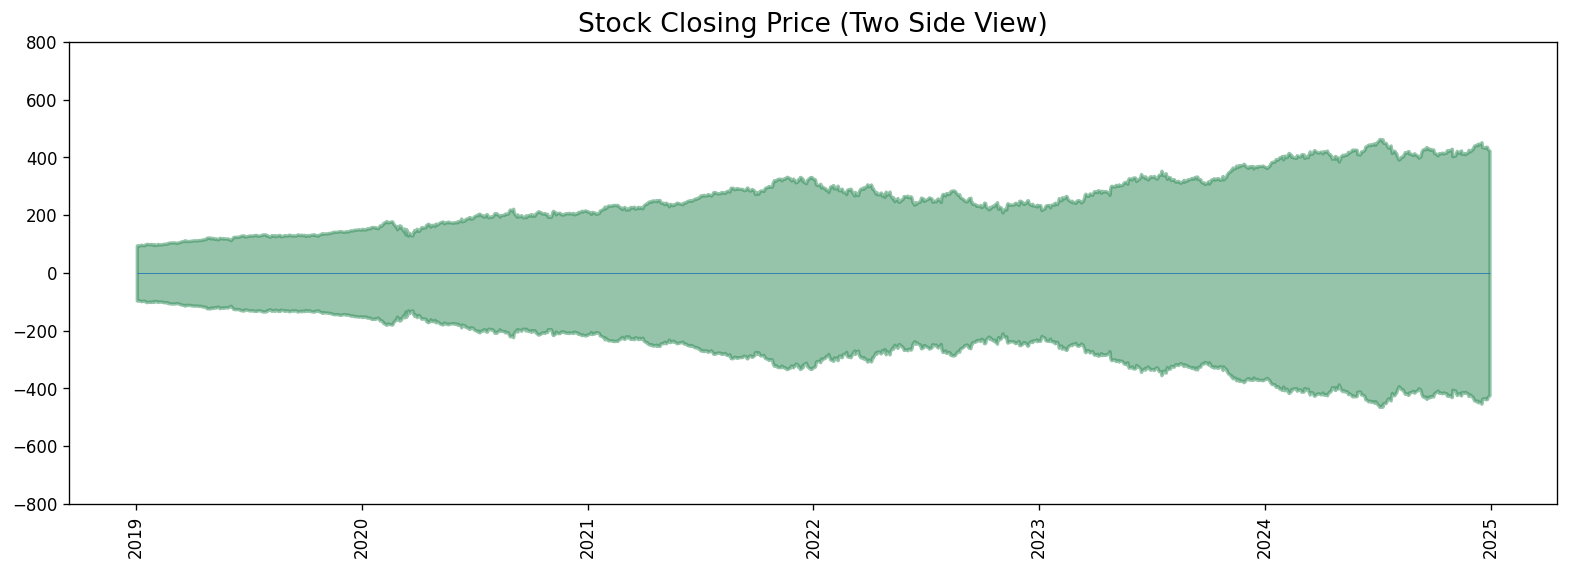

In [7]:
x = df.index.values
y1 = df['price'].values.flatten() # Flatten to make it 1-dimensional

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Stock Closing Price (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.xticks(rotation=90)
plt.show()

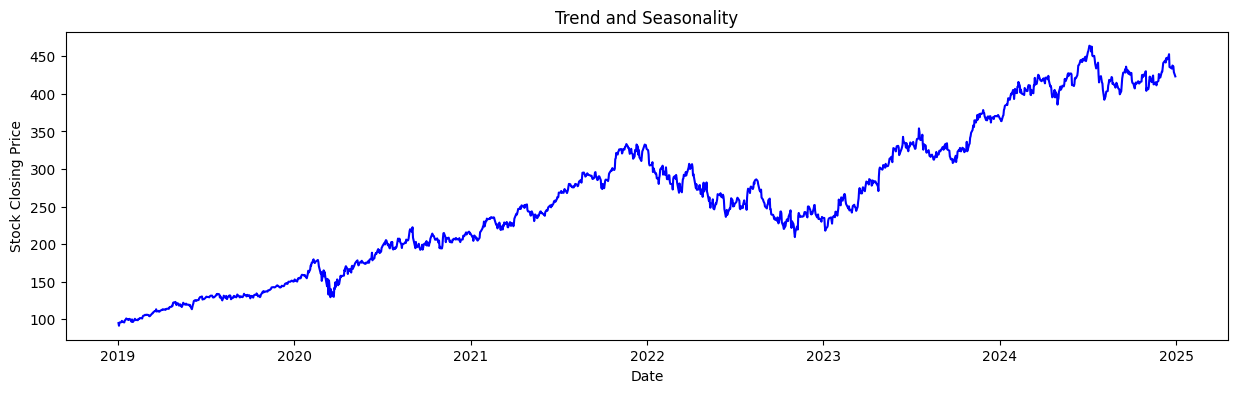

In [8]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Stock Closing Price', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df, x=df.index, y=df['price'], title='Trend and Seasonality')

## Decomposition of a Time Series

In [9]:
!pip install statsmodels

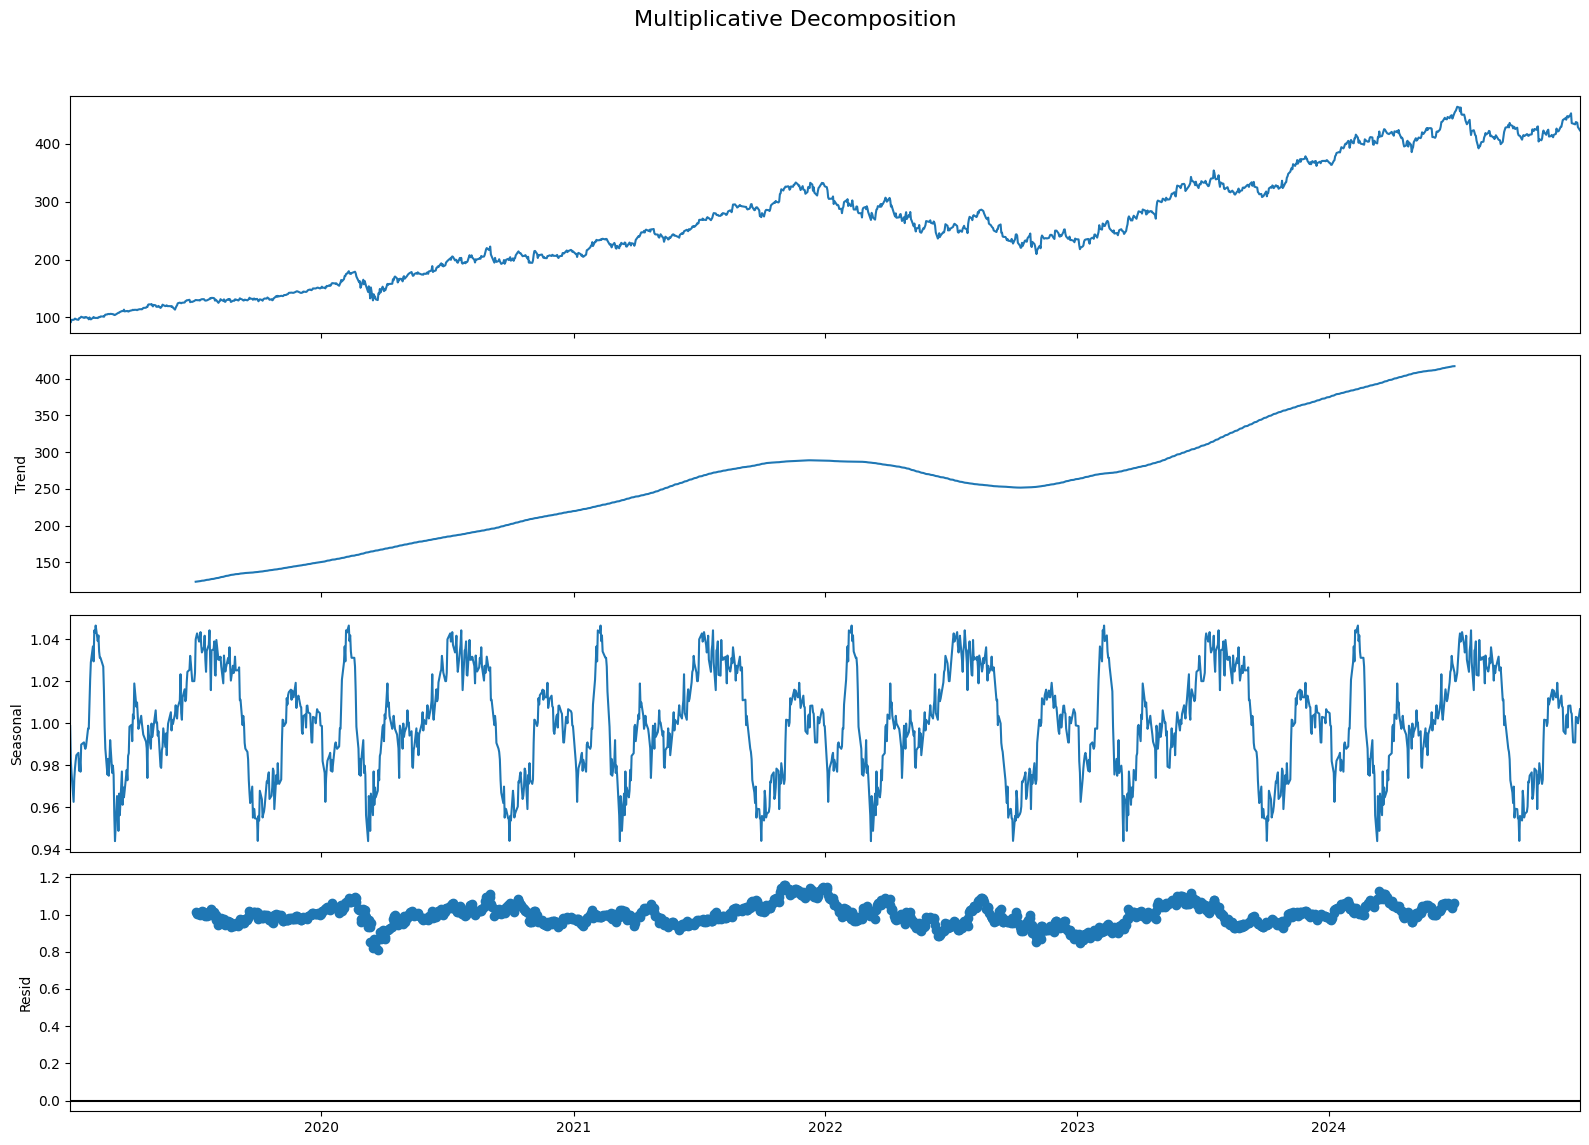

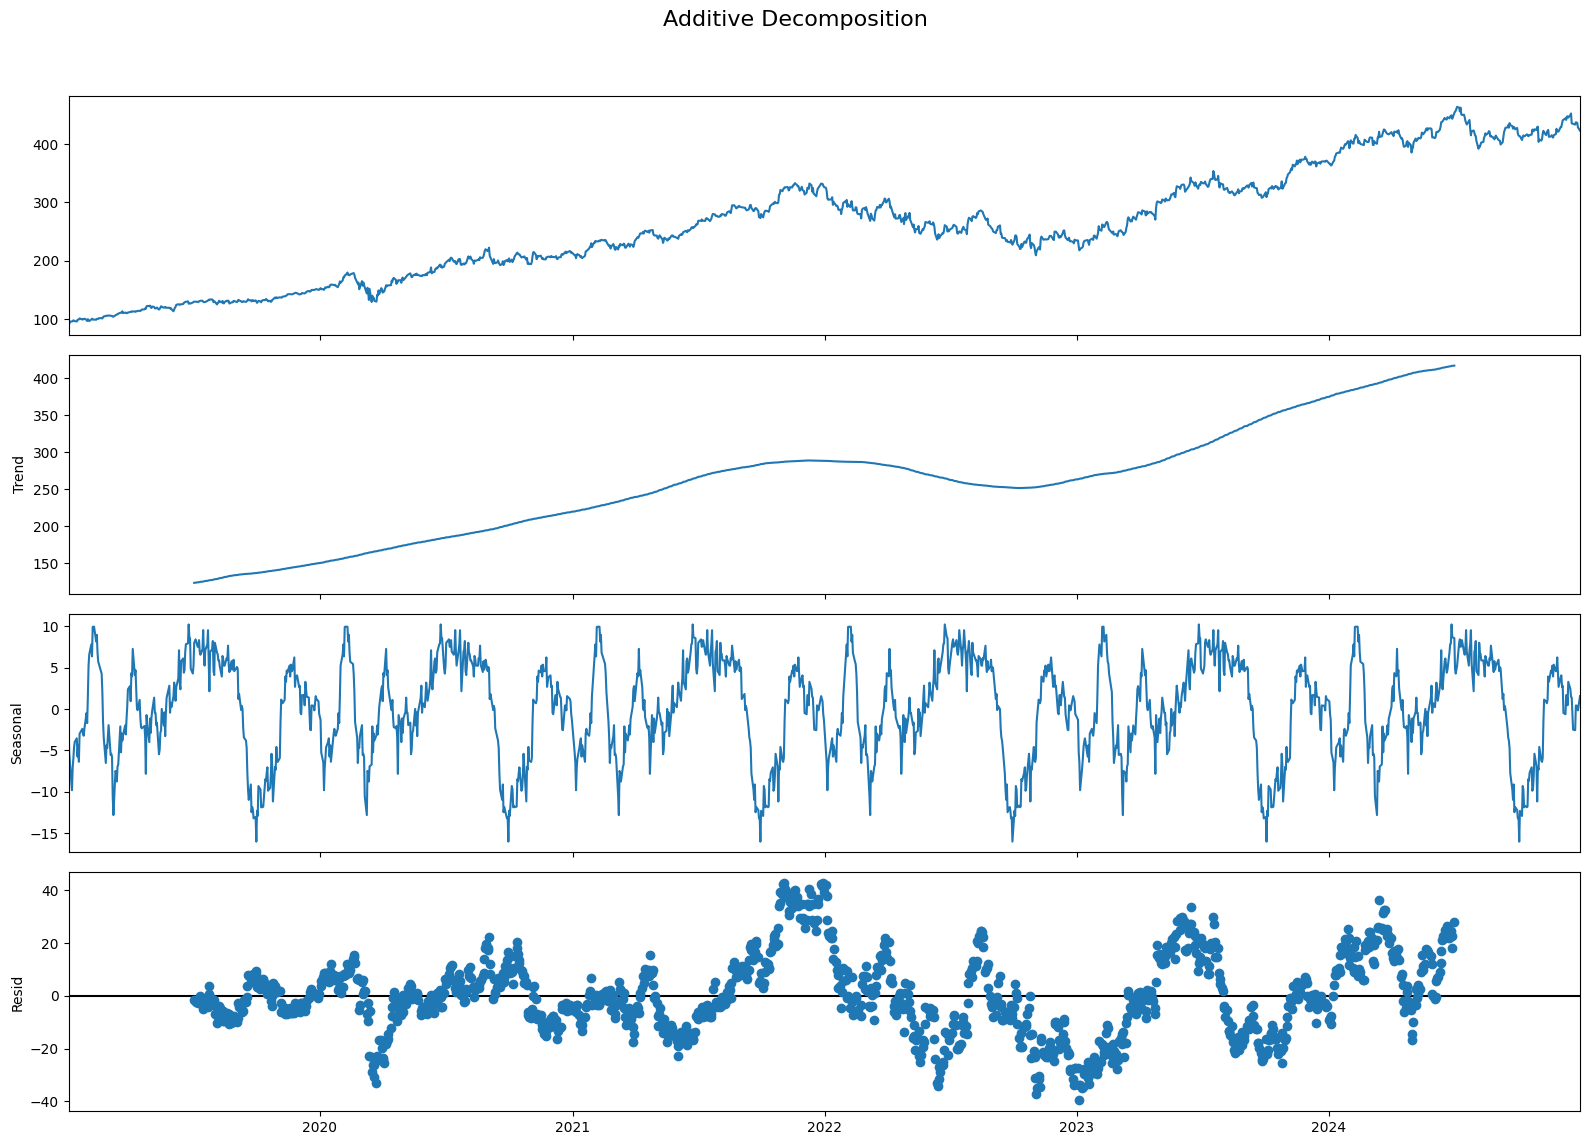

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['price'], model='multiplicative', period=252)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['price'], model='additive', period=252)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Detrend a Time Series

Text(0.5, 1.0, 'Closing price-Stock detrended by subtracting the least squares fit')

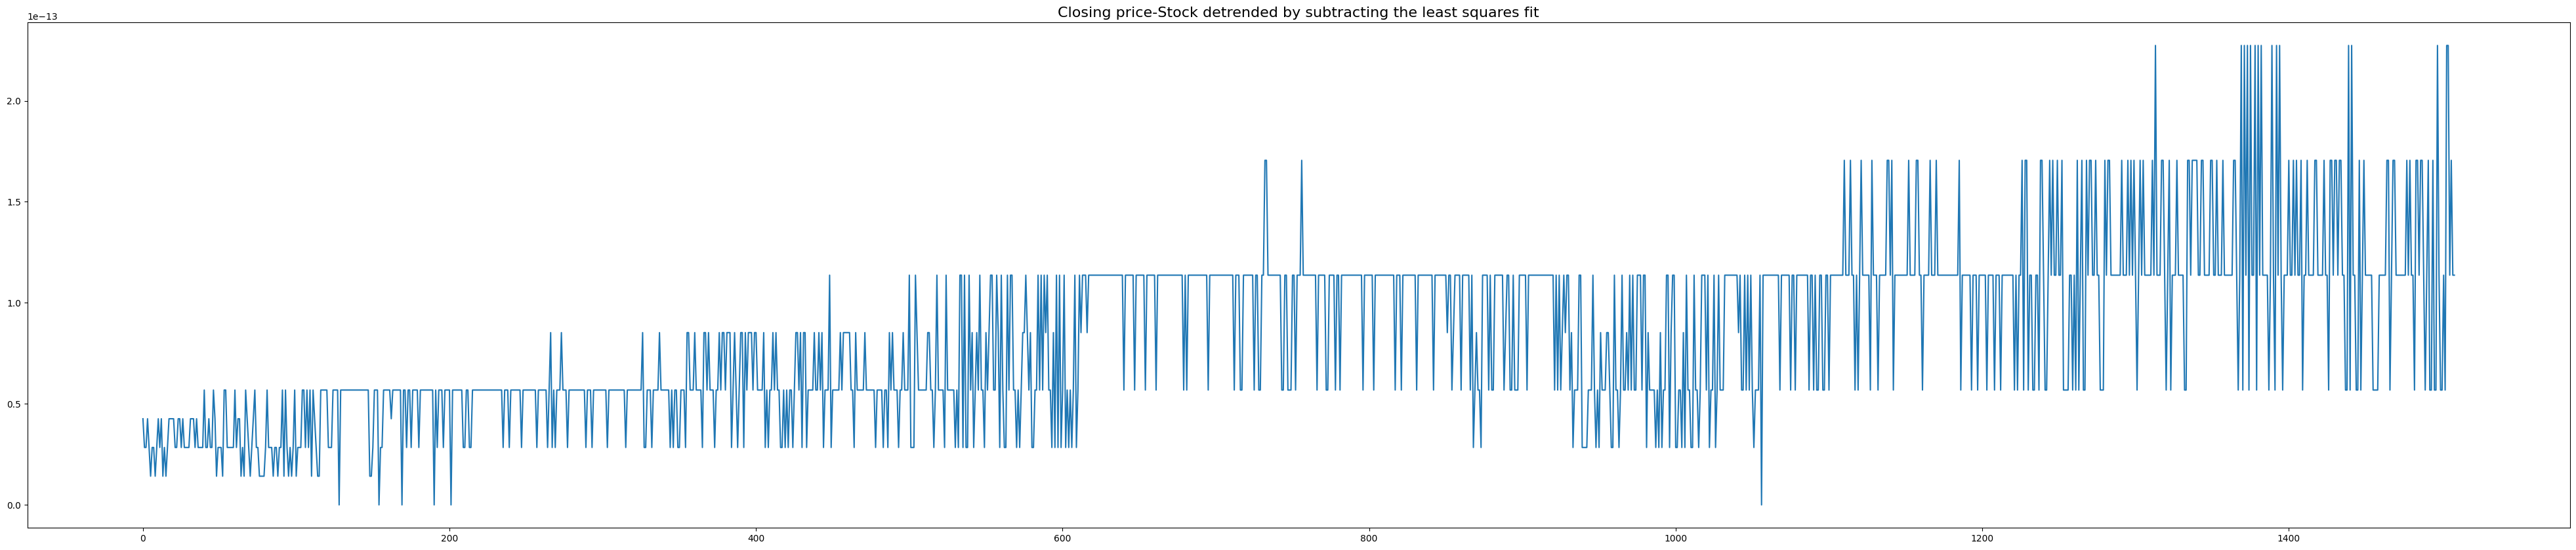

In [11]:
# Using scipy: Subtract the line of best fit
plt.figure(figsize=(50,10))
from scipy import signal
detrended = signal.detrend(df['price'].values)
plt.plot(detrended)
plt.title('Closing price-Stock detrended by subtracting the least squares fit', fontsize=16)

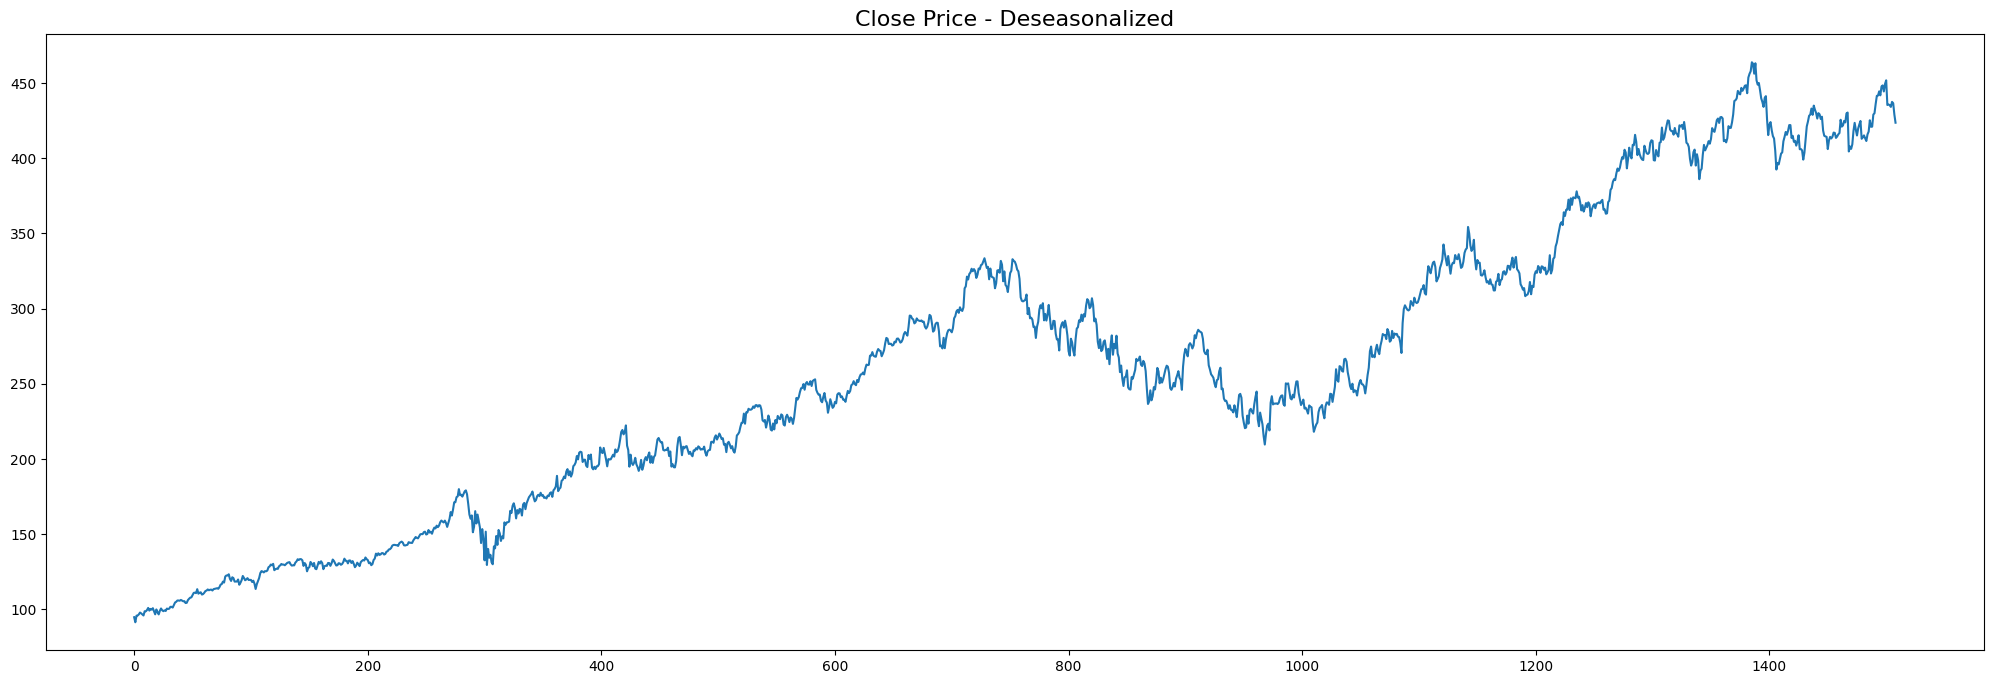

In [12]:
# Subtracting the Trend Component

# Time Series Decomposition
result_mul = seasonal_decompose(df['price'], model='multiplicative', period=12)

# Deseasonalize
deseasonalized = df['price'].values.flatten() / result_mul.seasonal.values.flatten()

# Plot
plt.figure(figsize=(25,8), dpi=100)
plt.plot(deseasonalized)
plt.title('Close Price - Deseasonalized', fontsize=16)
plt.show()

In [13]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

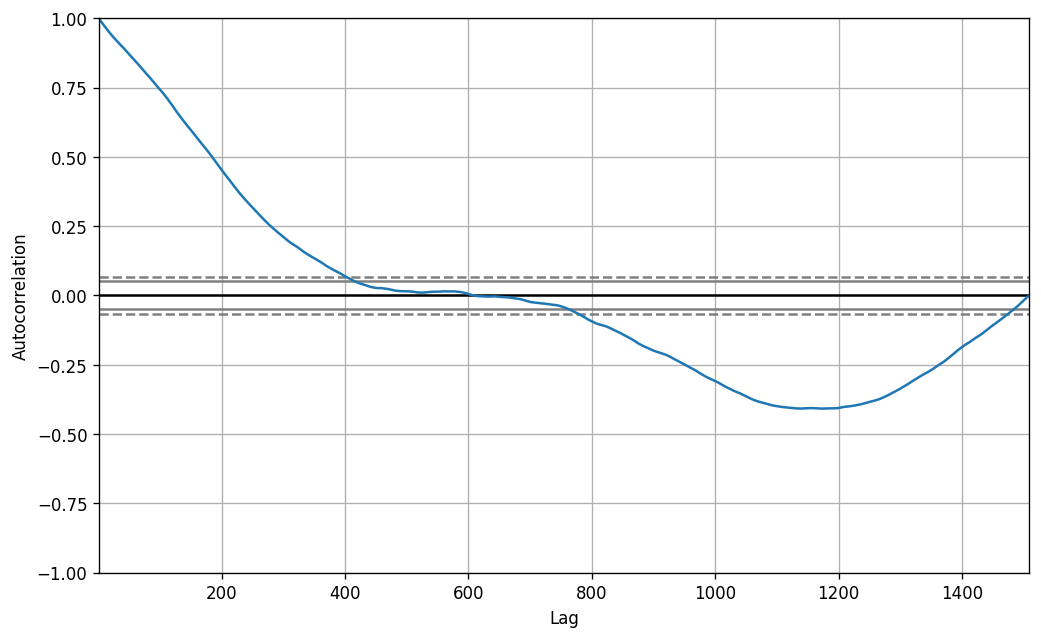

In [17]:
autocorrelation_plot(df['price', 'MSFT'].tolist())

### Autocorrelation and Partial Correlation

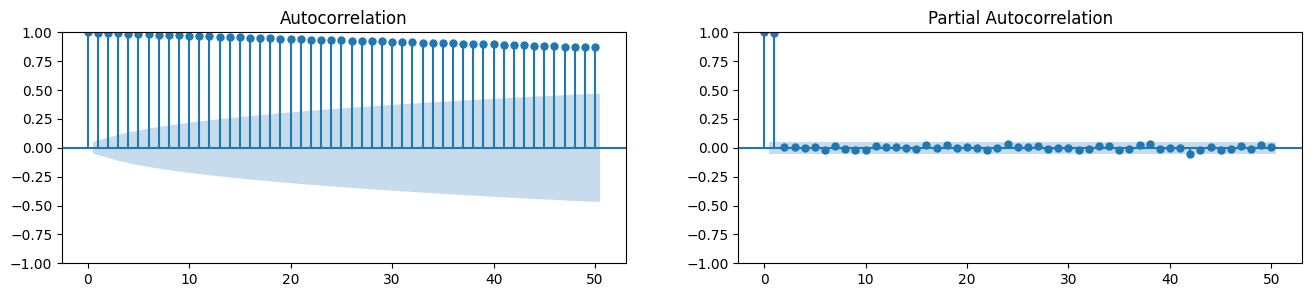

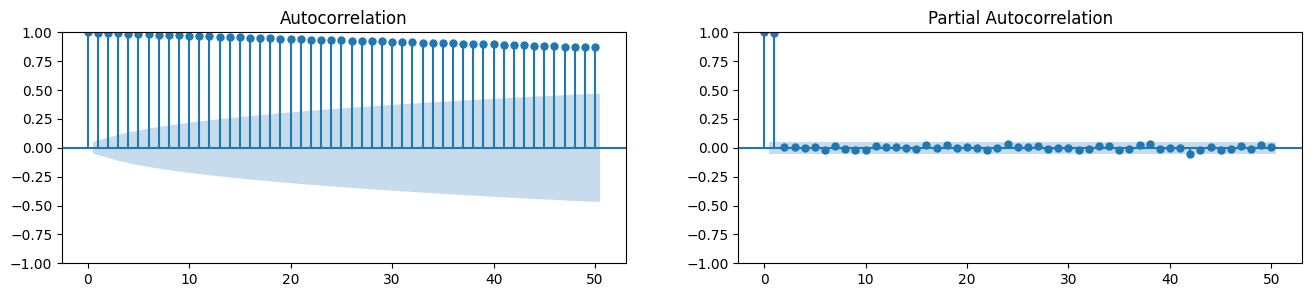

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df[('price', 'MSFT')].tolist(), lags=50, ax=axes[0])
plot_pacf(df[('price', 'MSFT')].tolist(), lags=50, ax=axes[1])

In [19]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.price.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.819168
p-value: 0.813427


**As p-value > 0.05 → Fail to reject H₀ → The series is non-stationary (it likely has a trend or seasonality), so we will be perform differencing**

### 1st Order Differencing

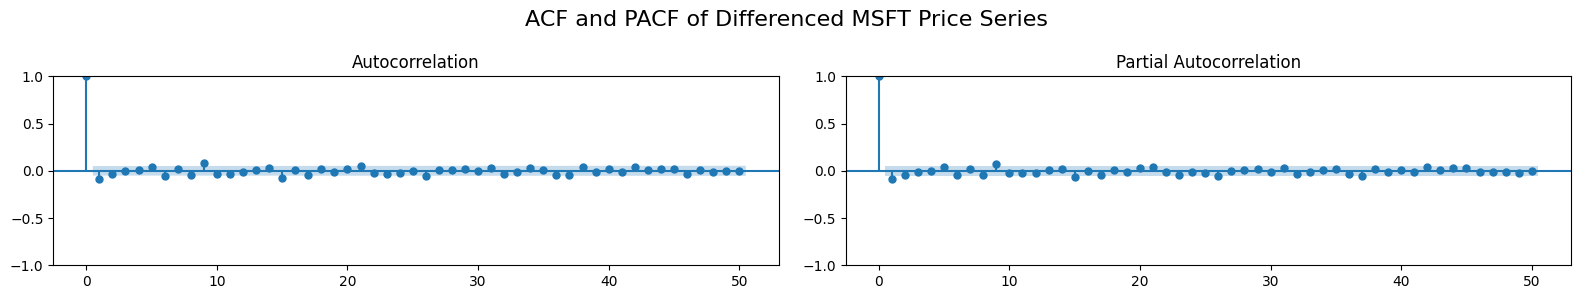

In [20]:
# Difference the time series to remove the trend
df_differenced = df[('price', 'MSFT')].diff().dropna()

# Plot ACF and PACF of the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df_differenced.tolist(), lags=50, ax=axes[0])
plot_pacf(df_differenced.tolist(), lags=50, ax=axes[1])
plt.suptitle('ACF and PACF of Differenced MSFT Price Series', fontsize=16)
plt.tight_layout()
plt.show()

**ACF Plot of Differenced Series:**

We still see a significant spike at lag 1. This is common in differenced time series and often suggests a moving average component of order 1 (MA(1)).
Beyond lag 1, the ACF values generally drop off quickly, and there aren't strong, sustained spikes at regular intervals that would clearly indicate a strong daily seasonality with a specific period (like the 252 trading days we considered earlier for yearly seasonality). There are some individual significant spikes at other lags, but they don't form a consistent, repeating pattern.


**PACF Plot of Differenced Series:**

The PACF shows a significant spike at lag 1 and then generally drops off quickly, with a few other significant spikes at later lags. This pattern, combined with the ACF, is also consistent with a dominant short-term correlation (like an AR(1) or MA(1) process) in the differenced series.

**Interpretation for Seasonality:**

Based on these plots, there isn't compelling evidence of a strong, consistent daily seasonality in the MSFT price data after removing the trend. While there might be some short-term dependencies (indicated by the spikes at small lags), a clear repeating pattern across longer lags (like 252 for yearly seasonality) is not strongly apparent in these plots of the differenced series.

This doesn't mean there's no seasonality at all, but it suggests that if seasonality exists, it might be weak, irregular, or perhaps better captured by more complex models. For stock price data, while there can be some weekly or monthly patterns, the overall price movement is often dominated by the trend and other factors rather than strong, fixed daily seasonality.

### Lag Plots

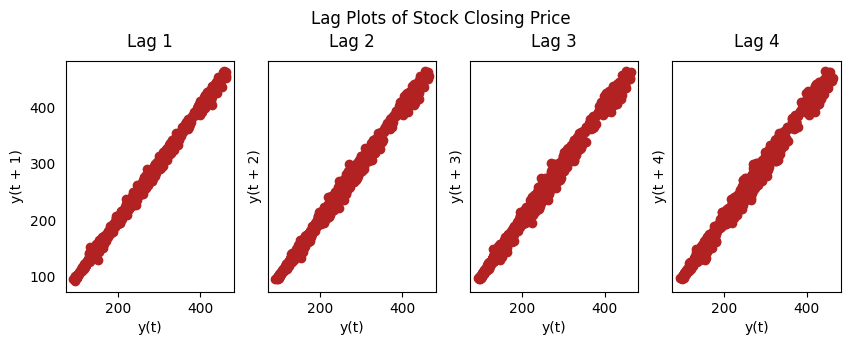

In [21]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['price'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Stock Closing Price', y=1.05)
plt.show()

The pattern in these lag plots, with points clustering around a positive diagonal, confirms the presence of significant positive autocorrelation in MSFT stock price series, especially at small lags. This is consistent with the strong trend we observed and the high values in the ACF plot at small lags.These lag plots visually reinforce the idea that past stock prices are strong predictors of future prices, particularly in the short term

### Moving Average

In [22]:
df1 = yf.download("MSFT", start="2019-01-01", end="2024-12-31")
df1.head()

/tmp/ipython-input-22-1568706980.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df1 = yf.download("MSFT", start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2019-01-02  94.945518  95.537048  92.898631  93.471384  35329300
2019-01-03  91.452660  94.072300  91.264868  93.987792  42579100
2019-01-04  95.706032  96.250618  92.889215  93.630978  44060600
2019-01-07  95.828110  96.964225  94.814061  95.433757  35656100
2019-01-08  96.522919  97.621475  95.499472  96.748262  31514400

In [23]:
df1.columns

MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

In [24]:
df1 = df1[['Close']].rename(columns={'Close': 'price1'})

In [25]:
df1 = df1.reset_index()
df1.columns = ["Date", "price1"]

In [26]:
df1.head()

Date     price1
0 2019-01-02  94.945518
1 2019-01-03  91.452660
2 2019-01-04  95.706032
3 2019-01-07  95.828110
4 2019-01-08  96.522919

In [27]:
df1.rename(columns={'Date': 'Date1'}, inplace=True)

In [28]:
df1.head()

Date1     price1
0 2019-01-02  94.945518
1 2019-01-03  91.452660
2 2019-01-04  95.706032
3 2019-01-07  95.828110
4 2019-01-08  96.522919

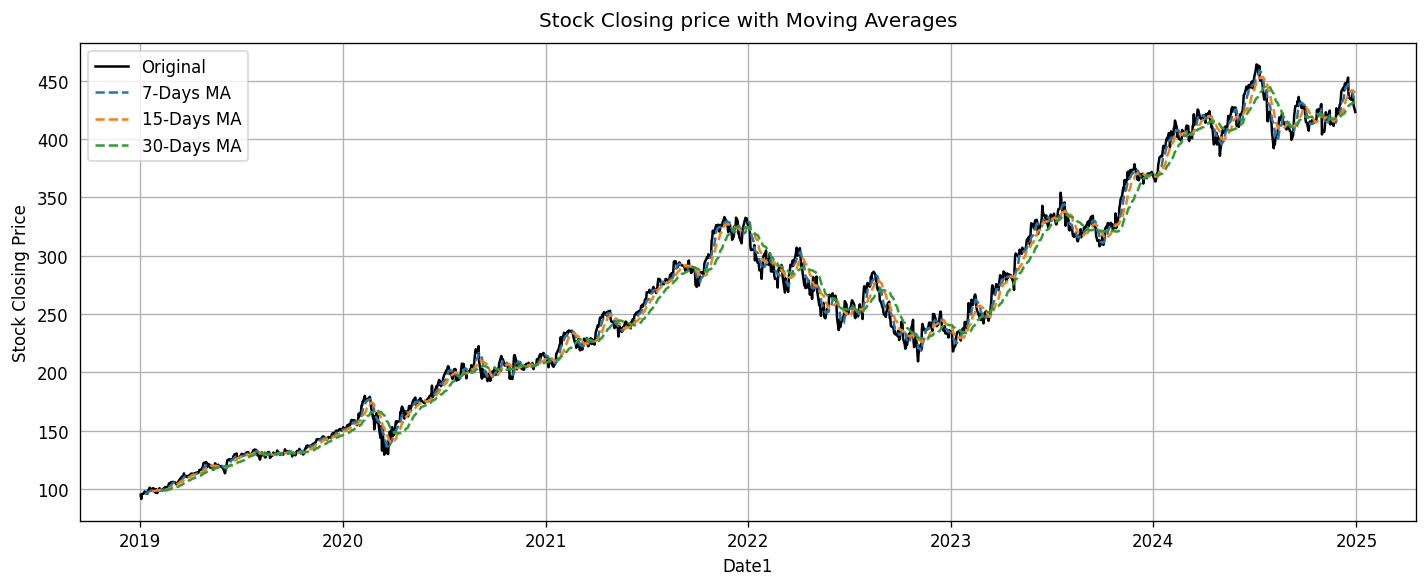

In [29]:

# Calculate moving averages
# Using 'price1' as the column name based on latest print output
df1['MA_7'] = df1['price1'].rolling(window=7).mean()
df1['MA_15'] = df1['price1'].rolling(window=15).mean()
df1['MA_30'] = df1['price1'].rolling(window=30).mean()

# Plot
plt.figure(figsize=(12,5))
# Explicitly provide Date1 for x-axis
plt.plot(df1['Date1'], df1['price1'], label='Original', color='black')
plt.plot(df1['Date1'], df1['MA_7'], label='7-Days MA', linestyle='--')
plt.plot(df1['Date1'], df1['MA_15'], label='15-Days MA', linestyle='--')
plt.plot(df1['Date1'], df1['MA_30'], label='30-Days MA', linestyle='--')

plt.title('Stock Closing price with Moving Averages')
plt.xlabel('Date1') # Now accurately reflects the x-axis data
plt.ylabel('Stock Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA

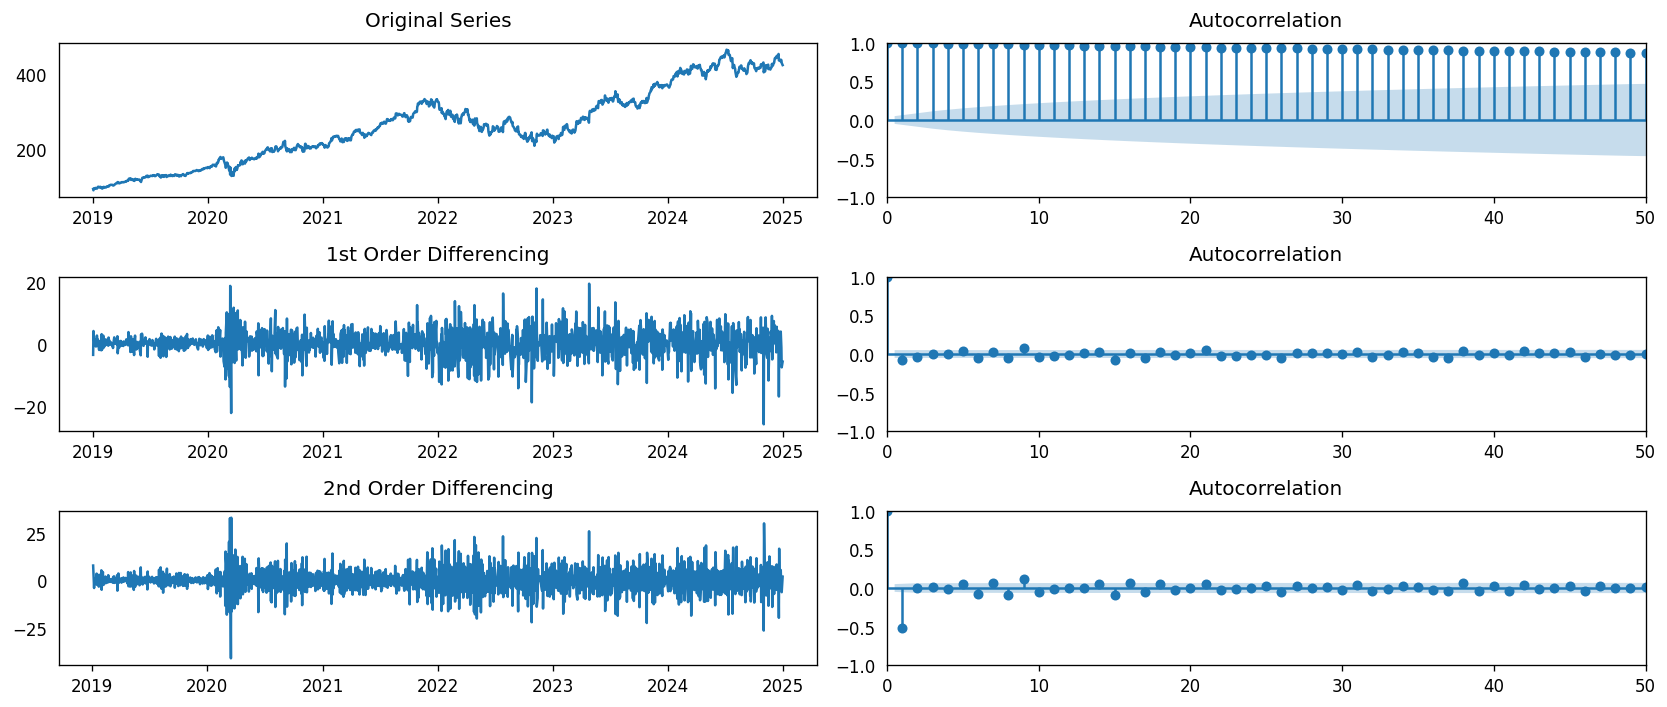

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (14, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot original series
axes[0, 0].plot(df['price'])
axes[0, 0].set_title('Original Series')
plot_acf(df['price'], ax=axes[0, 1], lags=50)
axes[0, 1].set_xlim([0, 50])  # Limit ACF x-axis to 50 lags

# First differencing
axes[1, 0].plot(df['price'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['price'].diff().dropna(), ax=axes[1, 1], lags=50)
axes[1, 1].set_xlim([0, 50])

# Second differencing
axes[2, 0].plot(df['price'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['price'].diff().diff().dropna(), ax=axes[2, 1], lags=50)
axes[2, 1].set_xlim([0, 50])

plt.tight_layout()
plt.show()

### AR Term

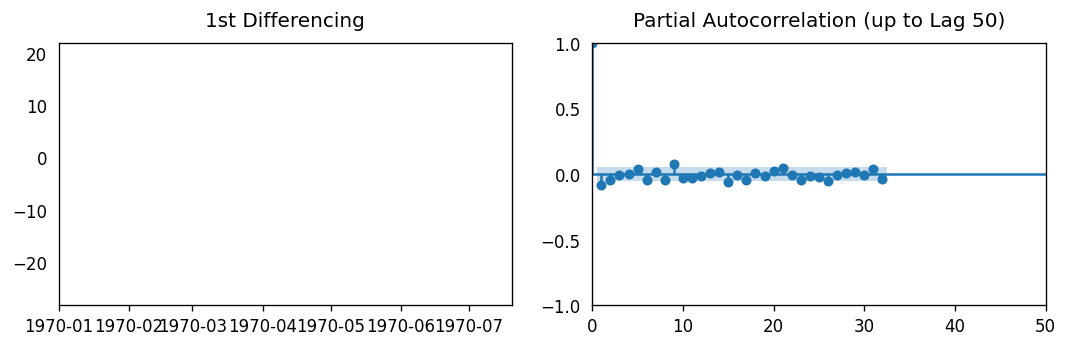

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2)  # No sharex so x-axes can differ

# Left: Differenced series
axes[0].plot(df.price.diff())
axes[0].set_title('1st Differencing')
axes[0].set_xlim(0, 200)  # Optional, controls time axis if needed

# Right: PACF plot with x-axis limited to 50 lags
plot_pacf(df.price.diff().dropna(), ax=axes[1])
axes[1].set_xlim(0, 50)
axes[1].set_title('Partial Autocorrelation (up to Lag 50)')

plt.tight_layout()
plt.show()

### MA term

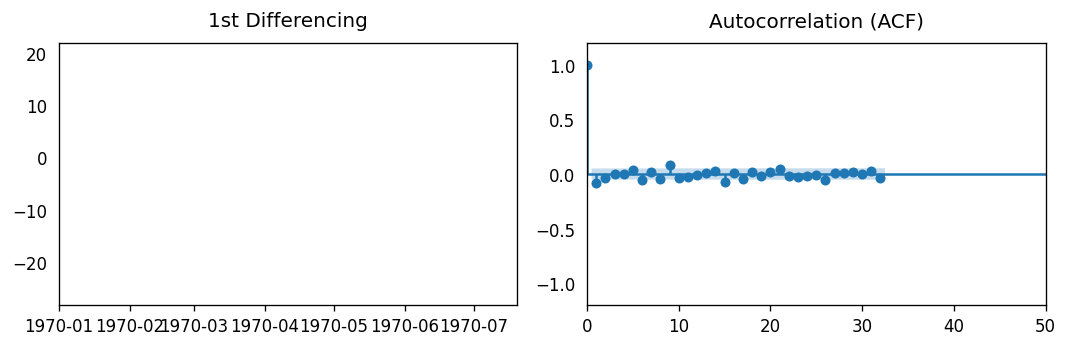

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2)  # Removed sharex for independent axes

# Left plot: First-order differencing
axes[0].plot(df.price.diff())
axes[0].set_title('1st Differencing')
axes[0].set_xlim(0, 200)  # Adjust based on your time series length

# Right plot: ACF with limited lags on x-axis
plot_acf(df.price.diff().dropna(), ax=axes[1])
axes[1].set_xlim(0, 50)   # Show only first 50 lags
axes[1].set_ylim(-1.2, 1.2)
axes[1].set_title('Autocorrelation (ACF)')

plt.tight_layout()
plt.show()

In [33]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.price, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 1509
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4383.581
Date:                Sun, 27 Jul 2025   AIC                           8775.163
Time:                        12:17:57   BIC                           8796.437
Sample:                             0   HQIC                          8783.086
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1053      0.644     -0.163      0.870      -1.368       1.158
ma.L1          0.0212      0.645      0.033      0.974      -1.244       1.286
ma.L2         -0.0439      0.056     -0.778      0.4

In [34]:
# 1,1,1 ARIMA Model
model = ARIMA(df.price, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 1509
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4383.784
Date:                Sun, 27 Jul 2025   AIC                           8773.568
Time:                        12:18:12   BIC                           8789.523
Sample:                             0   HQIC                          8779.510
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2795      0.213      1.311      0.190      -0.138       0.697
ma.L1         -0.3657      0.210     -1.745      0.081      -0.776       0.045
sigma2        19.6122      0.494     39.740      0.0

Interpretation of Coefficients and P-values:

For ar.L1, the p-value is 0.190. Since this is greater than the conventional significance level of 0.05, the autoregressive term at lag 1 is not statistically significant at the 5% level. This suggests that after differencing, the previous day's price change doesn't have a statistically significant linear relationship with the current day's price change in the presence of the MA(1) term.

For ma.L1, the p-value is 0.081. This is also greater than 0.05, so the moving average term at lag 1 is not statistically significant at the 5% level, although it's closer to being significant than the AR term. This suggests the previous day's forecast error is not a statistically significant predictor of the current day's price change.

The lack of statistical significance for both the AR(1) and MA(1) terms suggests that an ARIMA(1,1,1) model might not be the best fit for the differenced data. It indicates that the short-term autocorrelation observed after differencing might not be well captured by simple AR(1) or MA(1) components in this combined model.

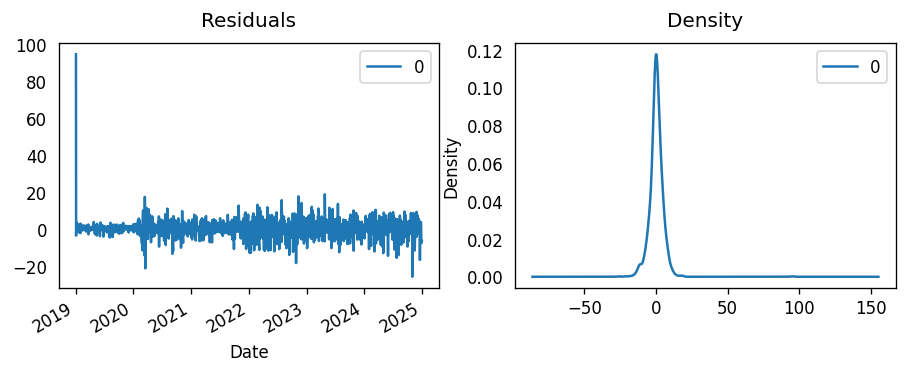

In [35]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual plots confirm some of the findings from the ARIMA summary:


The residuals are centered around zero, suggesting the model is not systematically over- or under-predicting.
However, the residuals show heteroskedasticity (non-constant variance) and are not normally distributed.


These characteristics of the residuals suggest that while the ARIMA(1,1,1) model has captured some of the linear dependencies and trend in the data, it doesn't fully account for the volatility clustering (periods of high and low volatility) and the non-normal distribution of the errors, which are common features of financial time series.


This means that while the model might provide reasonable point forecasts, the confidence intervals around those forecasts might not be accurate due to the non-constant variance and non-normal errors. For financial forecasting, models that can explicitly handle heteroskedasticity, like GARCH models, are often used in conjunction with ARIMA or other time series models.

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge pmdarima -y

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [5]:
import pmdarima as pm


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [7]:
# Split into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
# Fit auto ARIMA on training data
arima_model = pm.auto_arima(train, seasonal=False, m=7,
                            stepwise=True, suppress_warnings=True,
                            trace=True)

/usr/local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyth

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6911.893, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6917.743, Time=0.13 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6909.288, Time=0.26 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6908.423, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6918.224, Time=0.13 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6907.949, Time=1.82 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6909.884, Time=3.55 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6909.889, Time=5.18 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6908.795, Time=1.54 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6909.486, Time=0.75 sec


/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6909.520, Time=1.52 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.295 seconds


In [9]:
# Forecast
n_periods = len(test)
forecast, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = test.index

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# Convert to series
forecast_series = pd.Series(forecast, index=forecast_index)

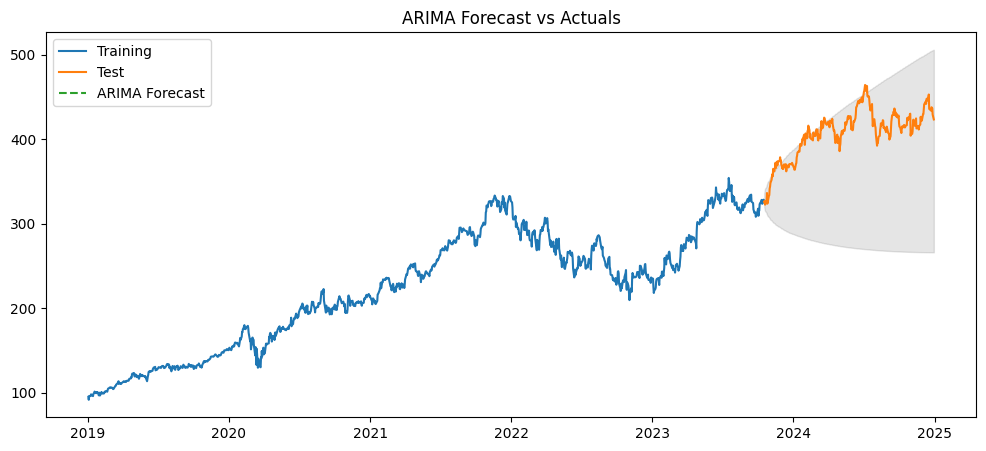

In [11]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['price'], label='Training')
plt.plot(test.index, test['price'], label='Test')
plt.plot(forecast_index, forecast_series, label='ARIMA Forecast', linestyle='--')
plt.fill_between(forecast_index, confint[:, 0], confint[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.show()

In [12]:
# Evaluation
rmse_arima = sqrt(mean_squared_error(test['price'], forecast))
mae_arima = mean_absolute_error(test['price'], forecast)

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE: {mae_arima:.2f}")

ARIMA RMSE: 54.04
ARIMA MAE: 50.62


#LSTM for Time Series Forecasting

## Prepare Data for LSTM

In [13]:
# Split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Scale only on training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['price']])
test_scaled = scaler.transform(test_df[['price']])

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def multi_step_metrics(y_true, y_pred):
    metrics = {}
    forecast_horizon = y_true.shape[1]
    for step in range(forecast_horizon):
        mse = mean_squared_error(y_true[:, step], y_pred[:, step])
        mae = mean_absolute_error(y_true[:, step], y_pred[:, step])
        rmse = sqrt(mse)
        mape = np.mean(np.abs((y_true[:, step] - y_pred[:, step]) / y_true[:, step])) * 100
        metrics[f"Step {step+1}"] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }
    return metrics

## ✅ 2. Single-Step Forecasting using LSTM

### 🔁 2.1 Prepare Dataset

In [15]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window_size = 30
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

### 🧠 2.2 Build & Train LSTM Model

In [16]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1269 - val_loss: 0.0028
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6584e-04 - val_loss: 0.0010
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/

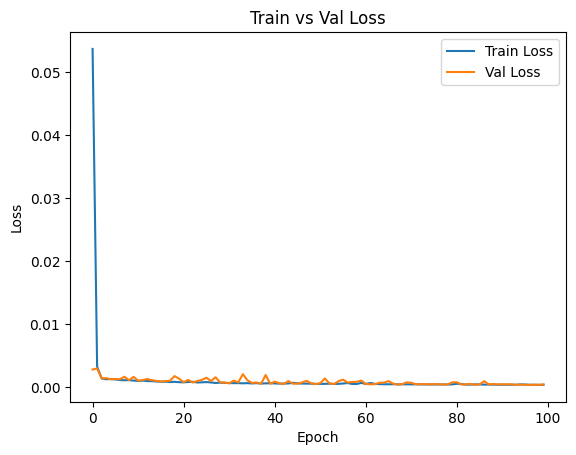

In [18]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 📈 2.3 Predict and Evaluate

In [19]:
# Predict
predictions = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
predictions_inv = scaler.inverse_transform(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [21]:
# Evaluate
rmse_lstm = sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae_lstm = mean_absolute_error(y_test_inv, predictions_inv)
mse_lstm = mean_squared_error(y_test_inv, predictions_inv)
mape_lstm = np.mean(np.abs((y_test_inv - predictions_inv) / y_test_inv)) * 100

# Print metrics
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM MSE: {mse_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2f}%")


LSTM RMSE: 6.64
LSTM MAE: 5.42
LSTM MSE: 44.13
LSTM MAPE: 1.30%


In [22]:
stepwise_metrics_ss = multi_step_metrics(y_test_inv, predictions_inv)
pprint.pprint(stepwise_metrics_ss)

{'Step 1': {'MAE': 5.421975865083596,
            'MAPE': np.float64(1.3008669389363527),
            'MSE': 44.12899222708091,
            'RMSE': 6.642965619893039}}


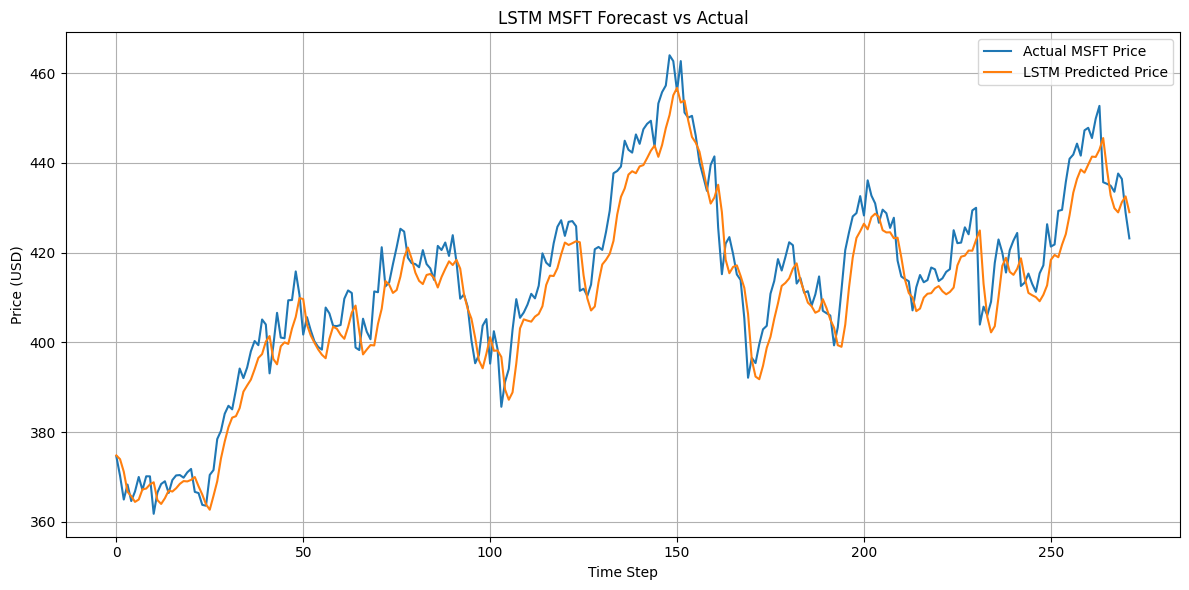

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual MSFT Price')
plt.plot(predictions_inv, label='LSTM Predicted Price')
plt.title("LSTM MSFT Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## ✅ 3. Multi-step Forecasting

In single-step, each input predicts the very next value:

Input:  [t-30, ..., t-1] → Predict: [t]


In multi-step, each input predicts a horizon (e.g., next 7 values):

Input:  [t-30, ..., t-1] → Predict: [t, t+1, ..., t+6]

### 🔁 3.1 Prepare dataset

In [24]:
# Redefine Sequence Generator (7-day ahead)

def create_multistep_sequences(data, input_window=30, forecast_horizon=7):
    X, y = [], []
    for i in range(len(data) - input_window - forecast_horizon + 1):
        X.append(data[i:i + input_window])
        y.append(data[i + input_window:i + input_window + forecast_horizon])
    return np.array(X), np.array(y)


In [25]:
# Create Multi-Step Sequences

forecast_horizon = 7
X_train, y_train = create_multistep_sequences(train_scaled, window_size, forecast_horizon)
X_test, y_test = create_multistep_sequences(test_scaled, window_size, forecast_horizon)

X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

### 🧠 3.2 Build and Train Multistep Model

In [26]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(forecast_horizon)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,351 (67.78 KB)

 Trainable params: 17,351 (67.78 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1909 - val_loss: 0.0136
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

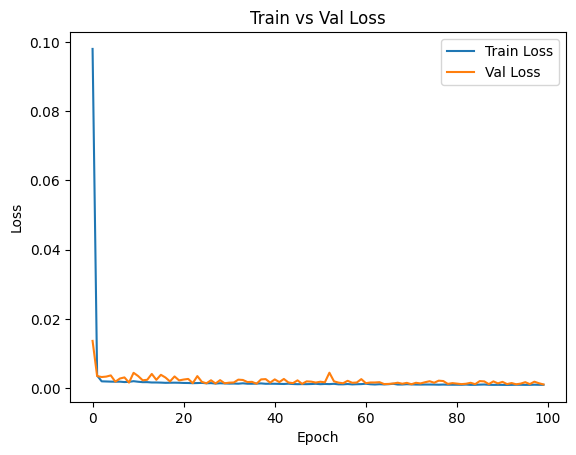

In [28]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 📈 3.3 Predict and Evaluate

In [29]:
pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
pred_inv = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(pred.shape)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [31]:
stepwise_metrics_ms = multi_step_metrics(y_test_inv, pred_inv)
pprint.pprint(stepwise_metrics_ms)

{'Step 1': {'MAE': 6.240391666727872,
            'MAPE': np.float64(5.610935854132752),
            'MSE': 55.96166171296349,
            'RMSE': 7.4807527504231475},
 'Step 2': {'MAE': 8.769278390066981,
            'MAPE': np.float64(5.674355366340476),
            'MSE': 109.05905095973137,
            'RMSE': 10.443134154061767},
 'Step 3': {'MAE': 8.666013330445262,
            'MAPE': np.float64(5.57877546306762),
            'MSE': 109.65295660896322,
            'RMSE': 10.471530767226119},
 'Step 4': {'MAE': 9.06506462383988,
            'MAPE': np.float64(5.514925605300192),
            'MSE': 119.5682511421105,
            'RMSE': 10.934726843506906},
 'Step 5': {'MAE': 13.328499241879129,
            'MAPE': np.float64(5.765548435538218),
            'MSE': 261.35494904636107,
            'RMSE': 16.166476086221174},
 'Step 6': {'MAE': 13.797154476768108,
            'MAPE': np.float64(5.802963052503884),
            'MSE': 284.6118229633778,
            'RMSE': 16.8704422

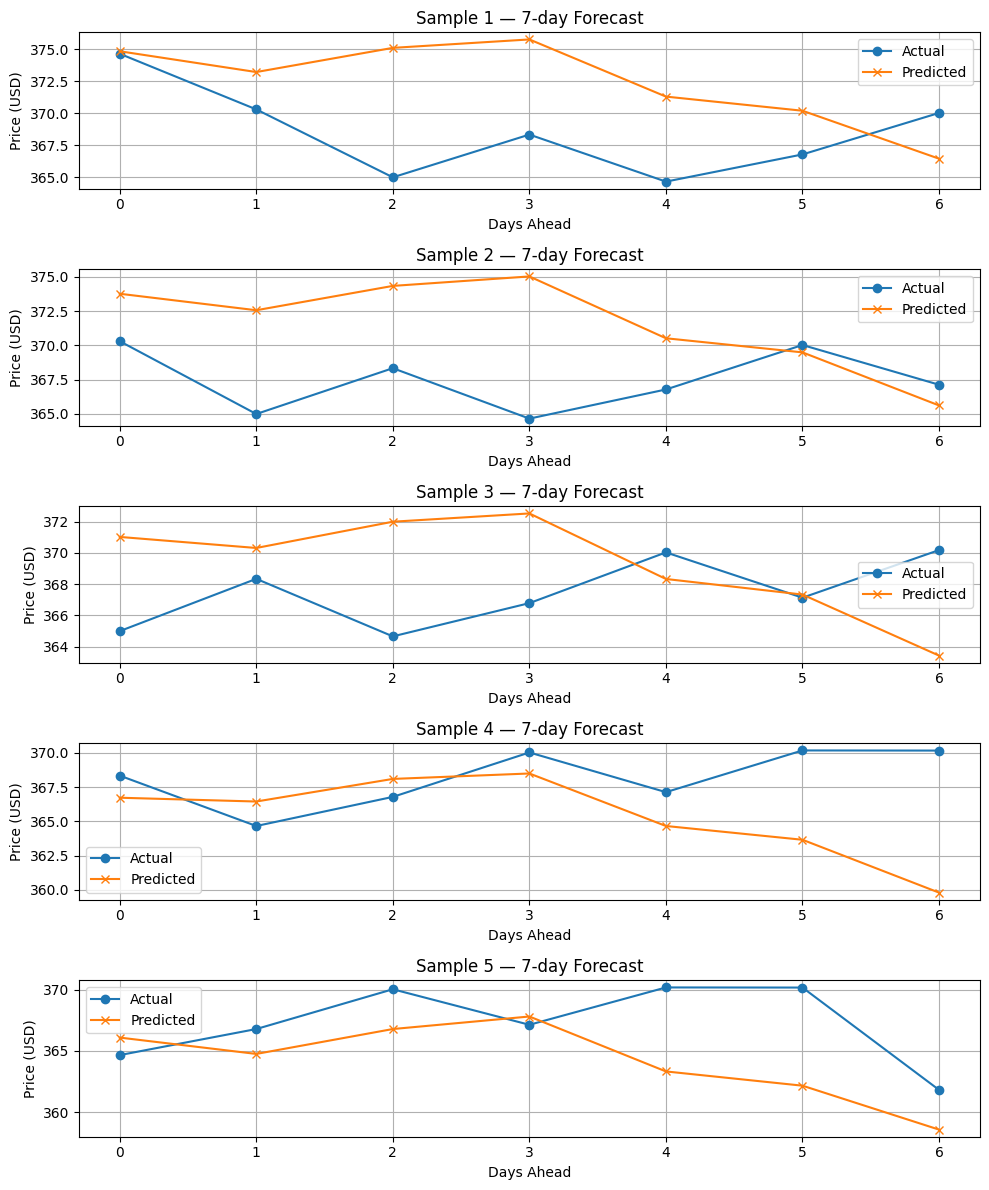

In [32]:
N = 5

plt.figure(figsize=(10, 12))
for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(y_test_inv[i], label='Actual', marker='o')
    plt.plot(pred_inv[i], label='Predicted', marker='x')
    plt.title(f'Sample {i+1} — 7-day Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Price (USD)')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

## ✅ 4. Walk-Forward (Rolling Window) Forecasting

Window 1: [t-30 to t-1]  → predict [t to t+6]  
Slide →  
Window 2: [t-29 to t]    → predict [t+1 to t+7]  

### 🔁 4.1 Prepare dataset

In [33]:
# Generate Rolling Input Windows from Test Set

def rolling_forecast(model, test_scaled, window_size=30, forecast_horizon=7):
    predictions = []
    i = 0
    while i + window_size + forecast_horizon <= len(test_scaled):
        input_seq = test_scaled[i:i + window_size].reshape(1, window_size, 1)
        pred = model.predict(input_seq, verbose=0)
        predictions.append(pred[0])
        i += 1  # move window forward by 1
    return np.array(predictions)


### 📈 4.2 Predict and Evaluate

In [ ]:
# Run the Rolling Forecast

rolling_preds_scaled = rolling_forecast(model, test_scaled, window_size, forecast_horizon)

# Align with actual labels
y_rolling_true = []
i = 0
while i + window_size + forecast_horizon <= len(test_scaled):
    y_rolling_true.append(test_scaled[i + window_size:i + window_size + forecast_horizon])
    i += 1

y_rolling_true = np.array(y_rolling_true)

In [ ]:
# Reshape and inverse transform
rolling_preds = scaler.inverse_transform(rolling_preds_scaled.reshape(-1, 1)).reshape(rolling_preds_scaled.shape)
y_rolling_true = scaler.inverse_transform(y_rolling_true.reshape(-1, 1)).reshape(y_rolling_true.shape)

In [ ]:
# Evaluate Walk-Forward Forecast

stepwise_metrics_wf = multi_step_metrics(y_rolling_true, rolling_preds)
pprint.pprint(stepwise_metrics_wf)

{'Step 1': {'MAE': 8.837983425046833,
            'MAPE': np.float64(11.806921696600547),
            'MSE': 106.9605759739957,
            'RMSE': 10.342174625000087},
 'Step 2': {'MAE': 7.430801932103628,
            'MAPE': np.float64(12.013800936677457),
            'MSE': 80.42303833945043,
            'RMSE': 8.967889291212867},
 'Step 3': {'MAE': 10.528366213598433,
            'MAPE': np.float64(11.664228265608775),
            'MSE': 164.45285815383718,
            'RMSE': 12.823917426193807},
 'Step 4': {'MAE': 9.975015832552794,
            'MAPE': np.float64(11.805871157051207),
            'MSE': 147.77936090140702,
            'RMSE': 12.15645346724969},
 'Step 5': {'MAE': 14.613118434147225,
            'MAPE': np.float64(11.56059622428782),
            'MSE': 310.73836836667493,
            'RMSE': 17.627772643379394},
 'Step 6': {'MAE': 14.720587041787295,
            'MAPE': np.float64(11.507374229139433),
            'MSE': 320.96792060649403,
            'RMSE': 17.

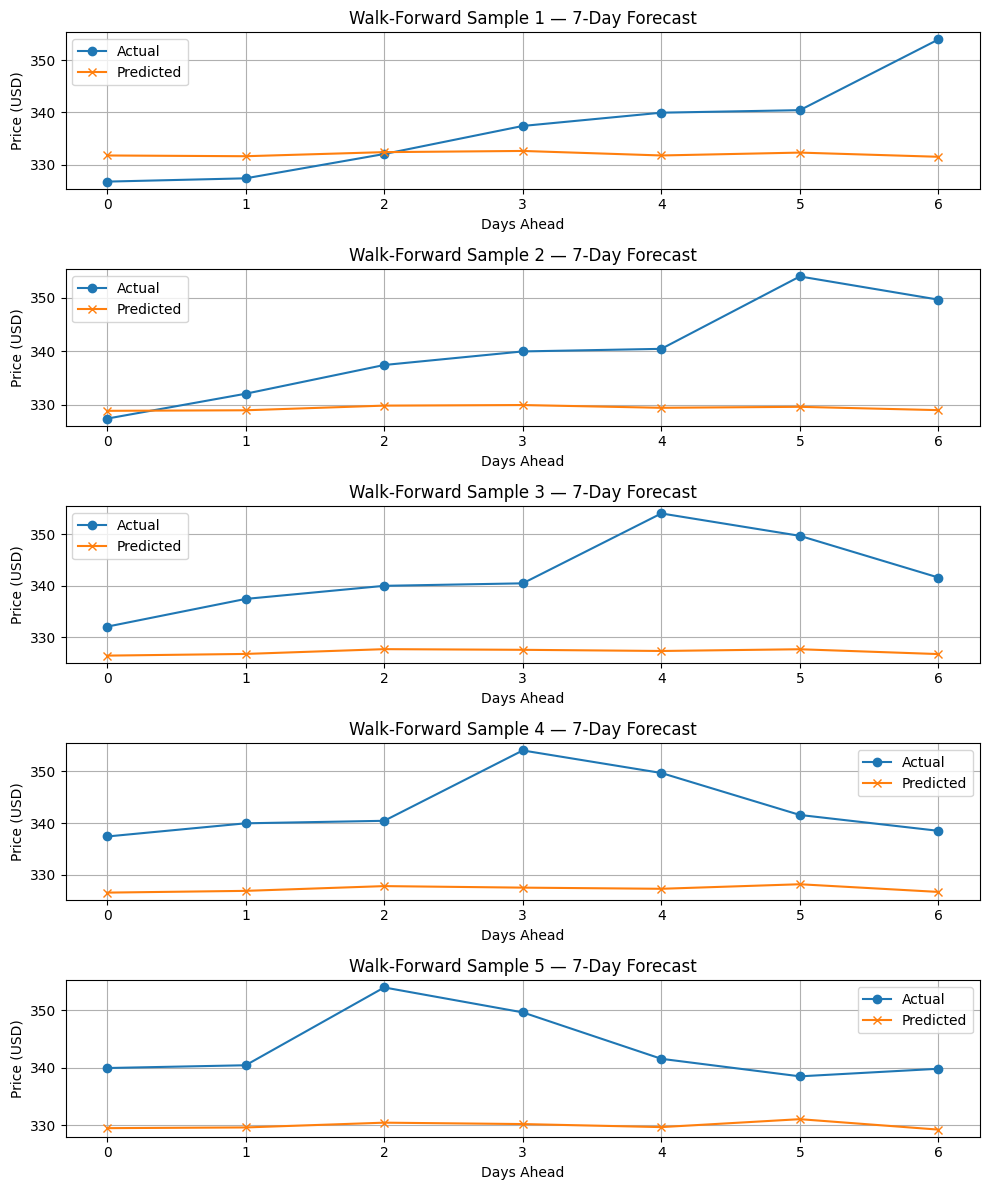

In [ ]:
N = 5
plt.figure(figsize=(10, 12))
for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(y_rolling_true[i], label='Actual', marker='o')
    plt.plot(rolling_preds[i], label='Predicted', marker='x')
    plt.title(f'Walk-Forward Sample {i+1} — 7-Day Forecast')
    plt.xlabel('Days Ahead')
    plt.ylabel('Price (USD)')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()


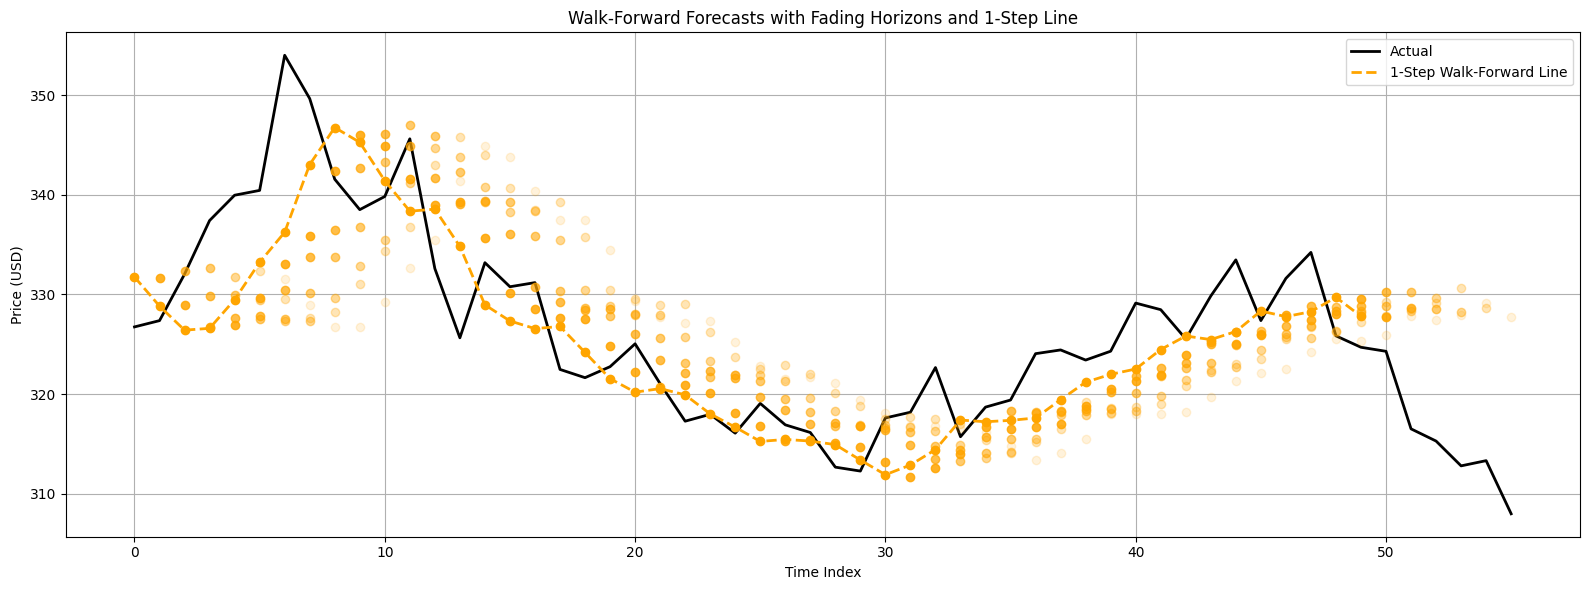

In [ ]:
N = 50  # Number of walk-forward forecast samples to use
forecast_horizon = rolling_preds.shape[1]

# Prepare actual timeline
actual_timeline = np.full(N + forecast_horizon, np.nan)
for i in range(N):
    actual_timeline[i:i+forecast_horizon] = y_rolling_true[i].flatten()

# Prepare line connecting 1-step forecasts
step_1_forecasts = [rolling_preds[i, 0] for i in range(N)]
step_1_timeline = np.arange(N)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(actual_timeline, color='black', linewidth=2, label='Actual')

# Plot all forecast points with fading alpha
for i in range(N):
    for j in range(forecast_horizon):
        t = i + j
        if t < len(actual_timeline):
            plt.plot(t, rolling_preds[i, j],
                     marker='o',
                     color='orange',
                     alpha=1.0 - j / forecast_horizon)

# Connect 1-step-ahead predictions
plt.plot(step_1_timeline, step_1_forecasts, color='orange', linestyle='--', linewidth=2, label='1-Step Walk-Forward Line')

plt.title("Walk-Forward Forecasts with Fading Horizons and 1-Step Line")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ✅ 4. Encoder Decoder LSTM

**Traditional LSTM**: Input (30) → Dense(7)

**Encoder-Decoder**: Encoder (30 steps) → Decoder (generates 7 steps)

### 🔁 4.1 Prepare dataset

In [ ]:
# teacher-forced decoder input

def create_encoder_decoder_data(data, input_window=30, forecast_horizon=7):
    X_encoder, X_decoder, y = [], [], []
    for i in range(len(data) - input_window - forecast_horizon + 1):
        X_encoder.append(data[i:i + input_window])
        # Decoder inputs (use 0s or last input for teacher forcing start)
        decoder_input = np.zeros((forecast_horizon, 1))
        decoder_input[1:] = data[i + input_window:i + input_window + forecast_horizon - 1]
        decoder_input[0] = data[i + input_window - 1]  # Start from last encoder value
        X_decoder.append(decoder_input)
        y.append(data[i + input_window:i + input_window + forecast_horizon])
    return np.array(X_encoder), np.array(X_decoder), np.array(y)

In [ ]:
X_enc_train, X_dec_train, y_train = create_encoder_decoder_data(train_scaled, 30, 7)
X_enc_test, X_dec_test, y_test = create_encoder_decoder_data(test_scaled, 30, 7)

### 🧠 4.2 Build and Train Multistep Model

In [ ]:
latent_dim = 64
forecast_horizon = 7
input_window = 30

# Encoder
encoder_inputs = Input(shape=(input_window, 1))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(forecast_horizon, 1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     16,896 │ input_layer_2[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 7, 64),   │     16,896 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │ lstm_2[0][1],     │
│                     │ (None, 64)]       │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7, 1)      │         65 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,857 (132.25 KB)

 Trainable params: 33,857 (132.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit([X_enc_train, X_dec_train], y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1039 - val_loss: 0.0018
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4366e-04 - val_loss: 0.0013
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8971e-04 - val_loss: 0.0011
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5130e-04 - val_loss: 0.0015
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0458e-04 - val_loss: 0.0014
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9975e-04 - val_loss: 0.0013
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9142e-04 - val_loss: 0.0011
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8309e-04 - val_loss: 0.0012
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2152e-04 - val_loss: 0.0011
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6527e-04 - val_loss: 0.0010
Epoch 12/100
45/45 ━━━━━

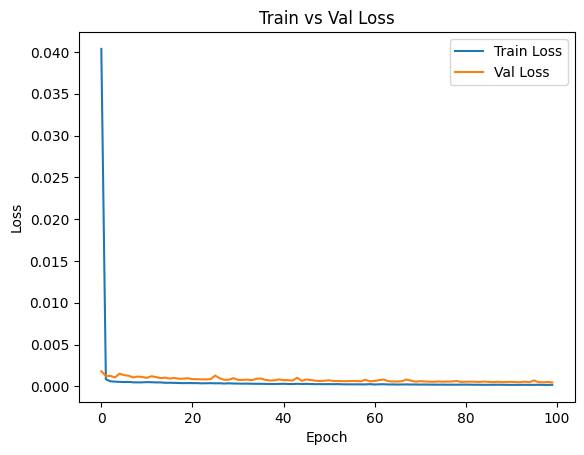

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 📈 4.3 Predict and Evaluate

In [ ]:
pred_test = model.predict([X_enc_test, X_dec_test])
# Inverse transform
pred_inv = scaler.inverse_transform(pred_test.reshape(-1, 1)).reshape(pred_test.shape)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
stepwise_metrics_ed = multi_step_metrics(y_test_inv, pred_inv)
pprint.pprint(stepwise_metrics_ed)

{'Step 1': {'MAE': 4.806249467813352,
            'MAPE': np.float64(1.2206868294581381),
            'MSE': 35.69362221874946,
            'RMSE': 5.974413964461239},
 'Step 2': {'MAE': 4.605990625532186,
            'MAPE': np.float64(1.1708341322431635),
            'MSE': 34.02986858233464,
            'RMSE': 5.833512542399703},
 'Step 3': {'MAE': 4.823324842738845,
            'MAPE': np.float64(1.2206640574139922),
            'MSE': 36.4478571275782,
            'RMSE': 6.037206069663202},
 'Step 4': {'MAE': 4.941667354074421,
            'MAPE': np.float64(1.2493446628395601),
            'MSE': 37.555563276247895,
            'RMSE': 6.12825940020883},
 'Step 5': {'MAE': 4.9563883851594435,
            'MAPE': np.float64(1.253574210618977),
            'MSE': 37.48126422944009,
            'RMSE': 6.122194396573837},
 'Step 6': {'MAE': 5.0086077864228535,
            'MAPE': np.float64(1.2666432068761606),
            'MSE': 37.948908103685774,
            'RMSE': 6.160268509

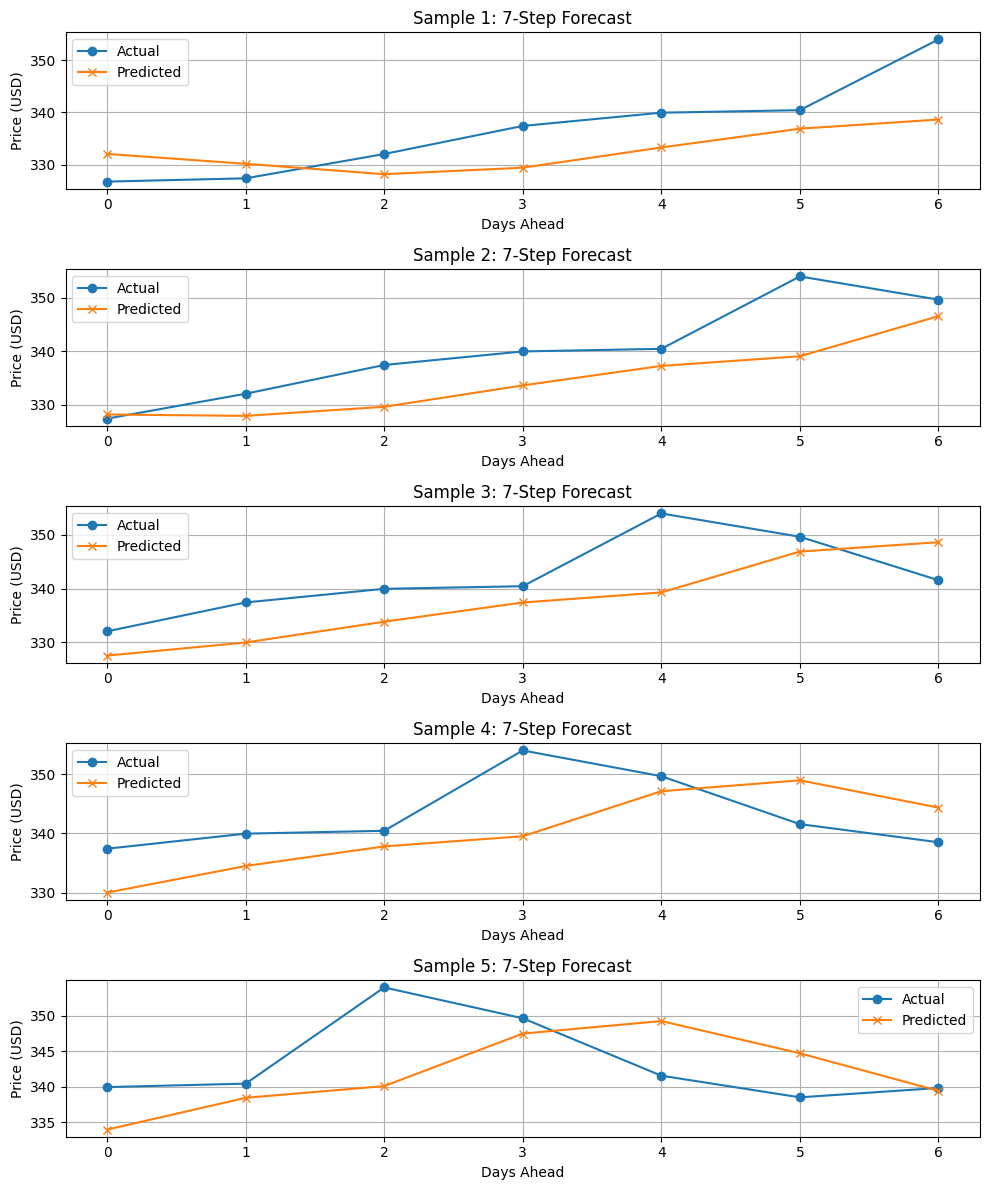

In [ ]:
N = 5
forecast_horizon = y_test_inv.shape[1]

plt.figure(figsize=(10, 12))
for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(y_test_inv[i], label='Actual', marker='o')
    plt.plot(pred_inv[i], label='Predicted', marker='x')
    plt.title(f"Sample {i+1}: 7-Step Forecast")
    plt.xlabel("Days Ahead")
    plt.ylabel("Price (USD)")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

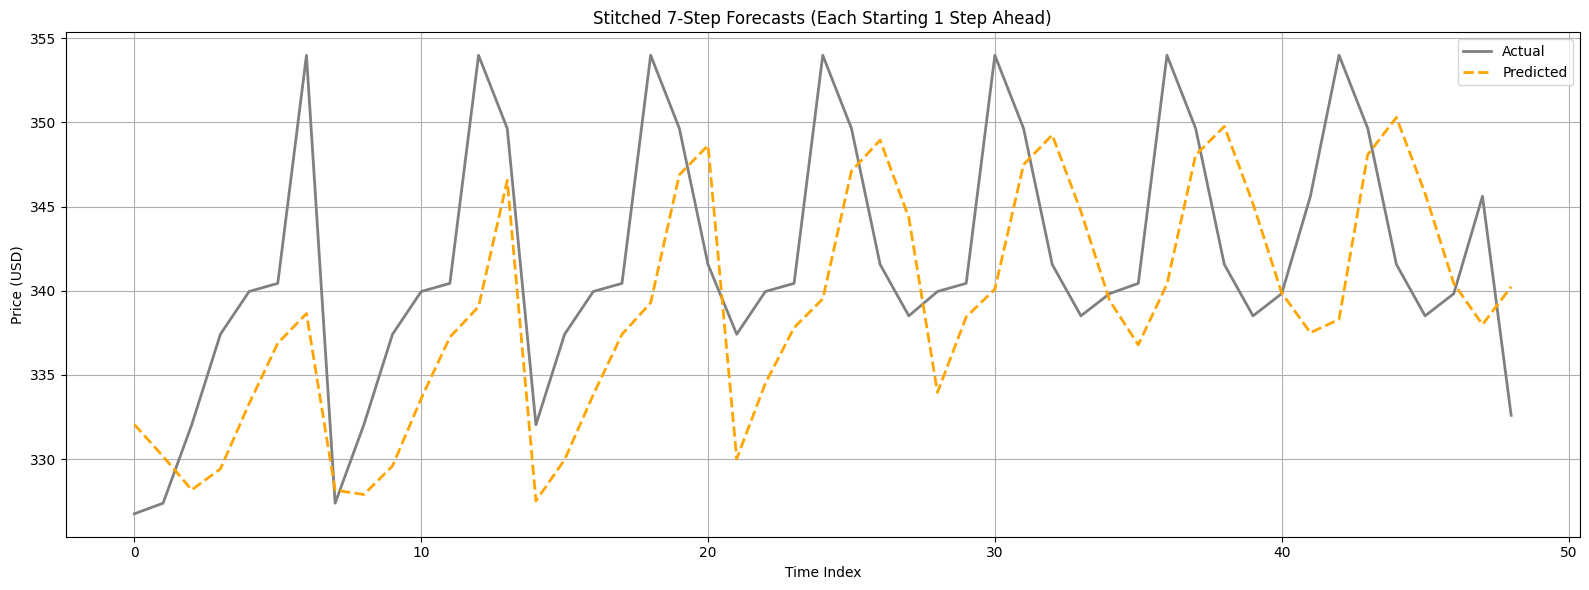

In [ ]:
# Number of forecast samples to stitch
N = 7
forecast_horizon = pred_inv.shape[1]

# Create stitched timelines
stitched_pred = []
stitched_actual = []

# Progressively append each step
for i in range(N):
    stitched_pred.extend(pred_inv[i].flatten())
    stitched_actual.extend(y_test_inv[i].flatten())

# Trim the actual to match the stitched length (in case of overrun)
min_len = min(len(stitched_pred), len(stitched_actual))
stitched_pred = stitched_pred[:min_len]
stitched_actual = stitched_actual[:min_len]

# Plot stitched forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(stitched_actual, label="Actual", color='gray', linewidth=2)
plt.plot(stitched_pred, label="Predicted", color='orange', linestyle='--', linewidth=2)
plt.title("Stitched 7-Step Forecasts (Each Starting 1 Step Ahead)")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Changing Window =30

In [ ]:
# teacher-forced decoder input

def create_encoder_decoder_data(data, input_window=30, forecast_horizon=30):
    X_encoder, X_decoder, y = [], [], []
    for i in range(len(data) - input_window - forecast_horizon + 1):
        X_encoder.append(data[i:i + input_window])
        # Decoder inputs (use 0s or last input for teacher forcing start)
        decoder_input = np.zeros((forecast_horizon, 1))
        decoder_input[1:] = data[i + input_window:i + input_window + forecast_horizon - 1]
        decoder_input[0] = data[i + input_window - 1]  # Start from last encoder value
        X_decoder.append(decoder_input)
        y.append(data[i + input_window:i + input_window + forecast_horizon])
    return np.array(X_encoder), np.array(X_decoder), np.array(y)

In [ ]:
X_enc_train, X_dec_train, y_train = create_encoder_decoder_data(train_scaled, 30, 30)
X_enc_test, X_dec_test, y_test = create_encoder_decoder_data(test_scaled, 30, 30)

In [ ]:
latent_dim = 64
forecast_horizon = 30
input_window = 30

# Encoder
encoder_inputs = Input(shape=(input_window, 1))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(forecast_horizon, 1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 64),      │     16,896 │ input_layer_6[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 30, 64),  │     16,896 │ input_layer_7[0]… │
│                     │ (None, 64),       │            │ lstm_6[0][1],     │
│                     │ (None, 64)]       │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 30, 1)     │         65 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,857 (132.25 KB)

 Trainable params: 33,857 (132.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit([X_enc_train, X_dec_train], y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0814 - val_loss: 0.0021
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5150e-04 - val_loss: 0.0012
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0394e-04 - val_loss: 0.0012
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7689e-04 - val_loss: 0.0012
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7118e-04 - val_loss: 0.0011
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8228e-04 - val_loss: 0.0011
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5948e-04 - val_loss: 0.0011
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4934e-04 - val_loss: 0.0011
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4218e-04 - val_loss: 0.0011
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9900e-04 - val_loss: 0.0010
Epoch 12/100
44/44 ━━

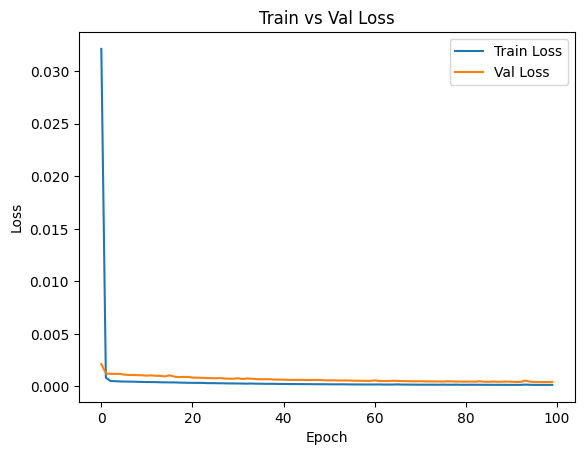

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred_test = model.predict([X_enc_test, X_dec_test])
# Inverse transform
pred_inv = scaler.inverse_transform(pred_test.reshape(-1, 1)).reshape(pred_test.shape)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
stepwise_metrics_ed = multi_step_metrics(y_test_inv, pred_inv)
pprint.pprint(stepwise_metrics_ed)

{'Step 1': {'MAE': 5.533545560615007,
            'MAPE': np.float64(1.4155123271714674),
            'MSE': 44.16319195336532,
            'RMSE': 6.645539252262778},
 'Step 10': {'MAE': 5.225634818853333,
             'MAPE': np.float64(1.321182314782301),
             'MSE': 40.19839842996268,
             'RMSE': 6.340220692528193},
 'Step 11': {'MAE': 5.144324369208757,
             'MAPE': np.float64(1.3008050111723977),
             'MSE': 39.30108871364554,
             'RMSE': 6.269058040379395},
 'Step 12': {'MAE': 5.059926587481831,
             'MAPE': np.float64(1.2800706100620605),
             'MSE': 38.23339827134556,
             'RMSE': 6.1833161225466675},
 'Step 13': {'MAE': 4.986826608347338,
             'MAPE': np.float64(1.261144215406629),
             'MSE': 37.383467320236385,
             'RMSE': 6.11420210004841},
 'Step 14': {'MAE': 4.92143879380337,
             'MAPE': np.float64(1.243072850080055),
             'MSE': 36.600584018117274,
             'R

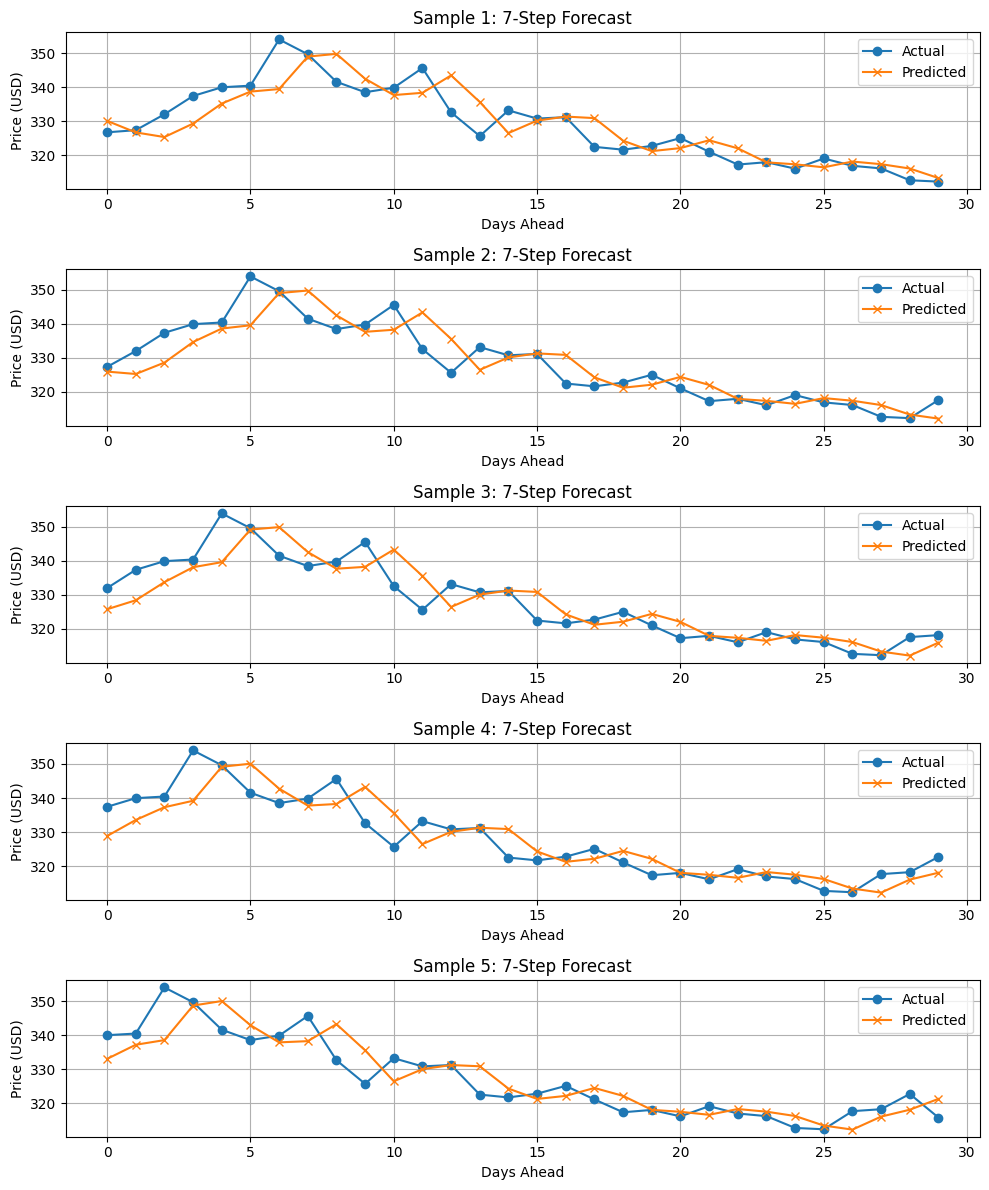

In [ ]:
N = 5
forecast_horizon = y_test_inv.shape[1]

plt.figure(figsize=(10, 12))
for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(y_test_inv[i], label='Actual', marker='o')
    plt.plot(pred_inv[i], label='Predicted', marker='x')
    plt.title(f"Sample {i+1}: 7-Step Forecast")
    plt.xlabel("Days Ahead")
    plt.ylabel("Price (USD)")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

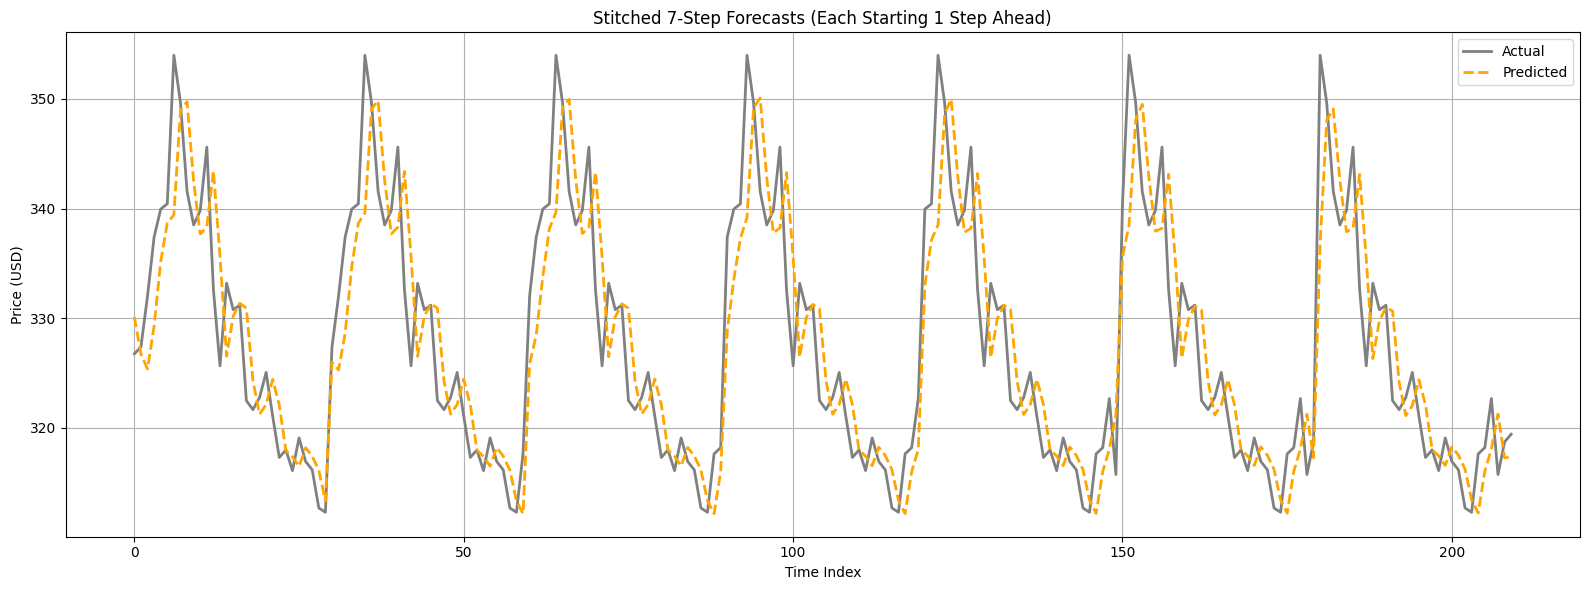

In [ ]:
# Number of forecast samples to stitch
N = 7
forecast_horizon = pred_inv.shape[1]

# Create stitched timelines
stitched_pred = []
stitched_actual = []

# Progressively append each step
for i in range(N):
    stitched_pred.extend(pred_inv[i].flatten())
    stitched_actual.extend(y_test_inv[i].flatten())

# Trim the actual to match the stitched length (in case of overrun)
min_len = min(len(stitched_pred), len(stitched_actual))
stitched_pred = stitched_pred[:min_len]
stitched_actual = stitched_actual[:min_len]

# Plot stitched forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(stitched_actual, label="Actual", color='gray', linewidth=2)
plt.plot(stitched_pred, label="Predicted", color='orange', linestyle='--', linewidth=2)
plt.title("Stitched 7-Step Forecasts (Each Starting 1 Step Ahead)")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary

In this notebook 5-years data of Microsoft was taken and analyzed from 2019 to 2024. Step by step approach was used starting from Decomposition, Moving Average then ARIMA Model, then LSTM Single Step and Multi-step also Encoder Decoder LSTM was used with Multiple inputs and outputs. It has been observed then **Encoder-Decoder LSTM works better than other Models**

## Compilation of Visual Graphs to understand working of each model

### Microsoft Stock Closing Price 2019 to 2024

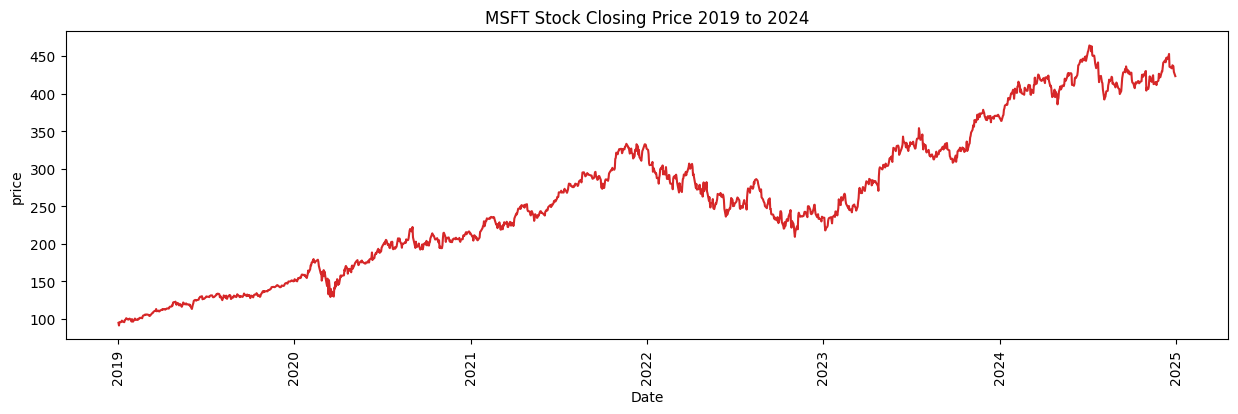

### Microsoft Stock Closing Price - Two Sided View

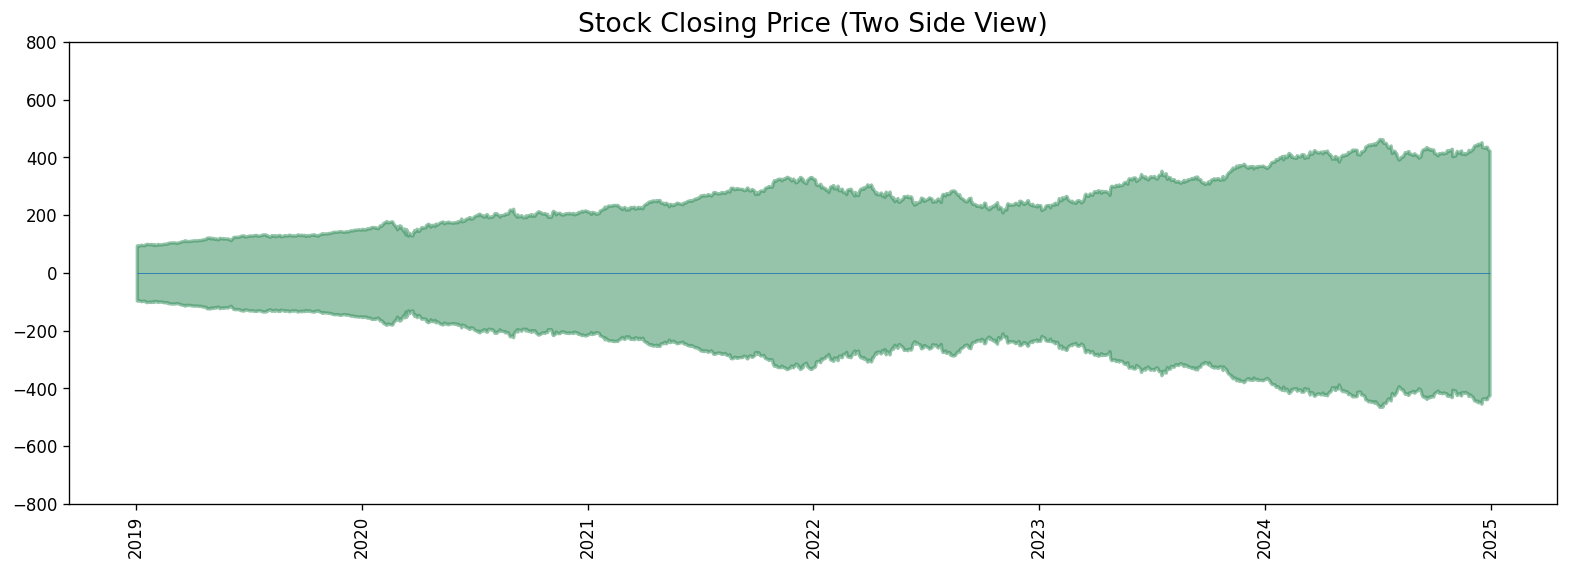

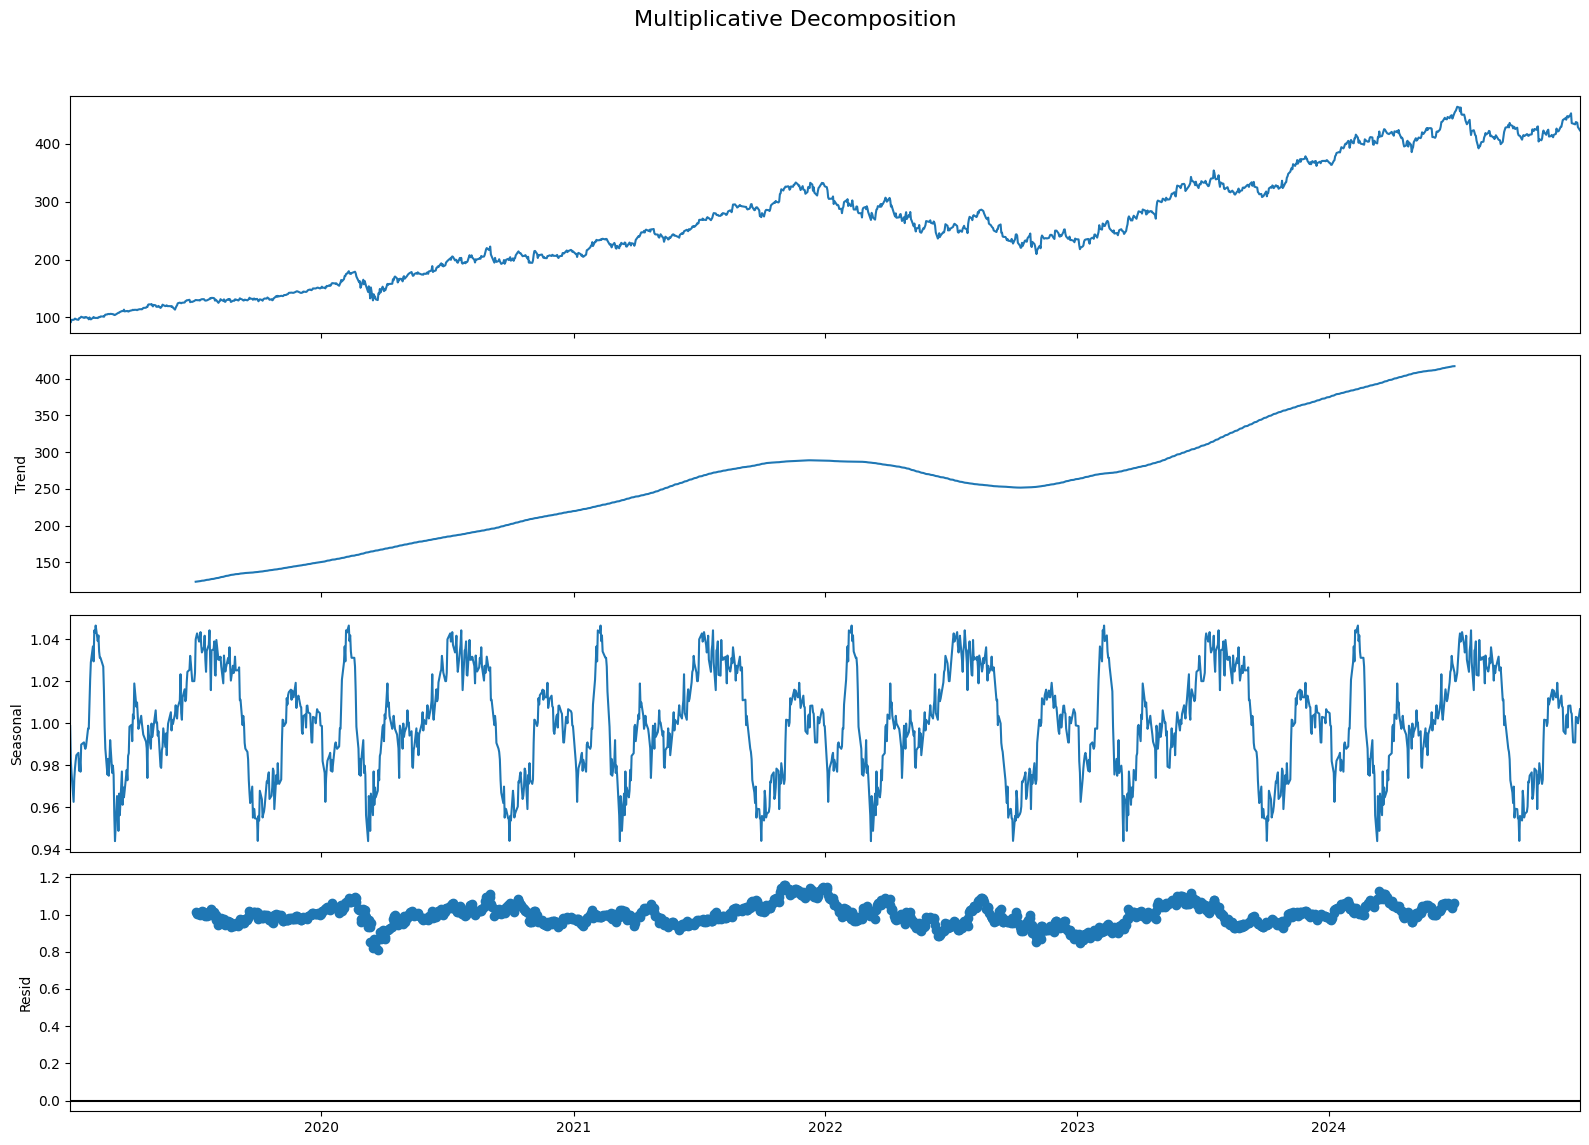

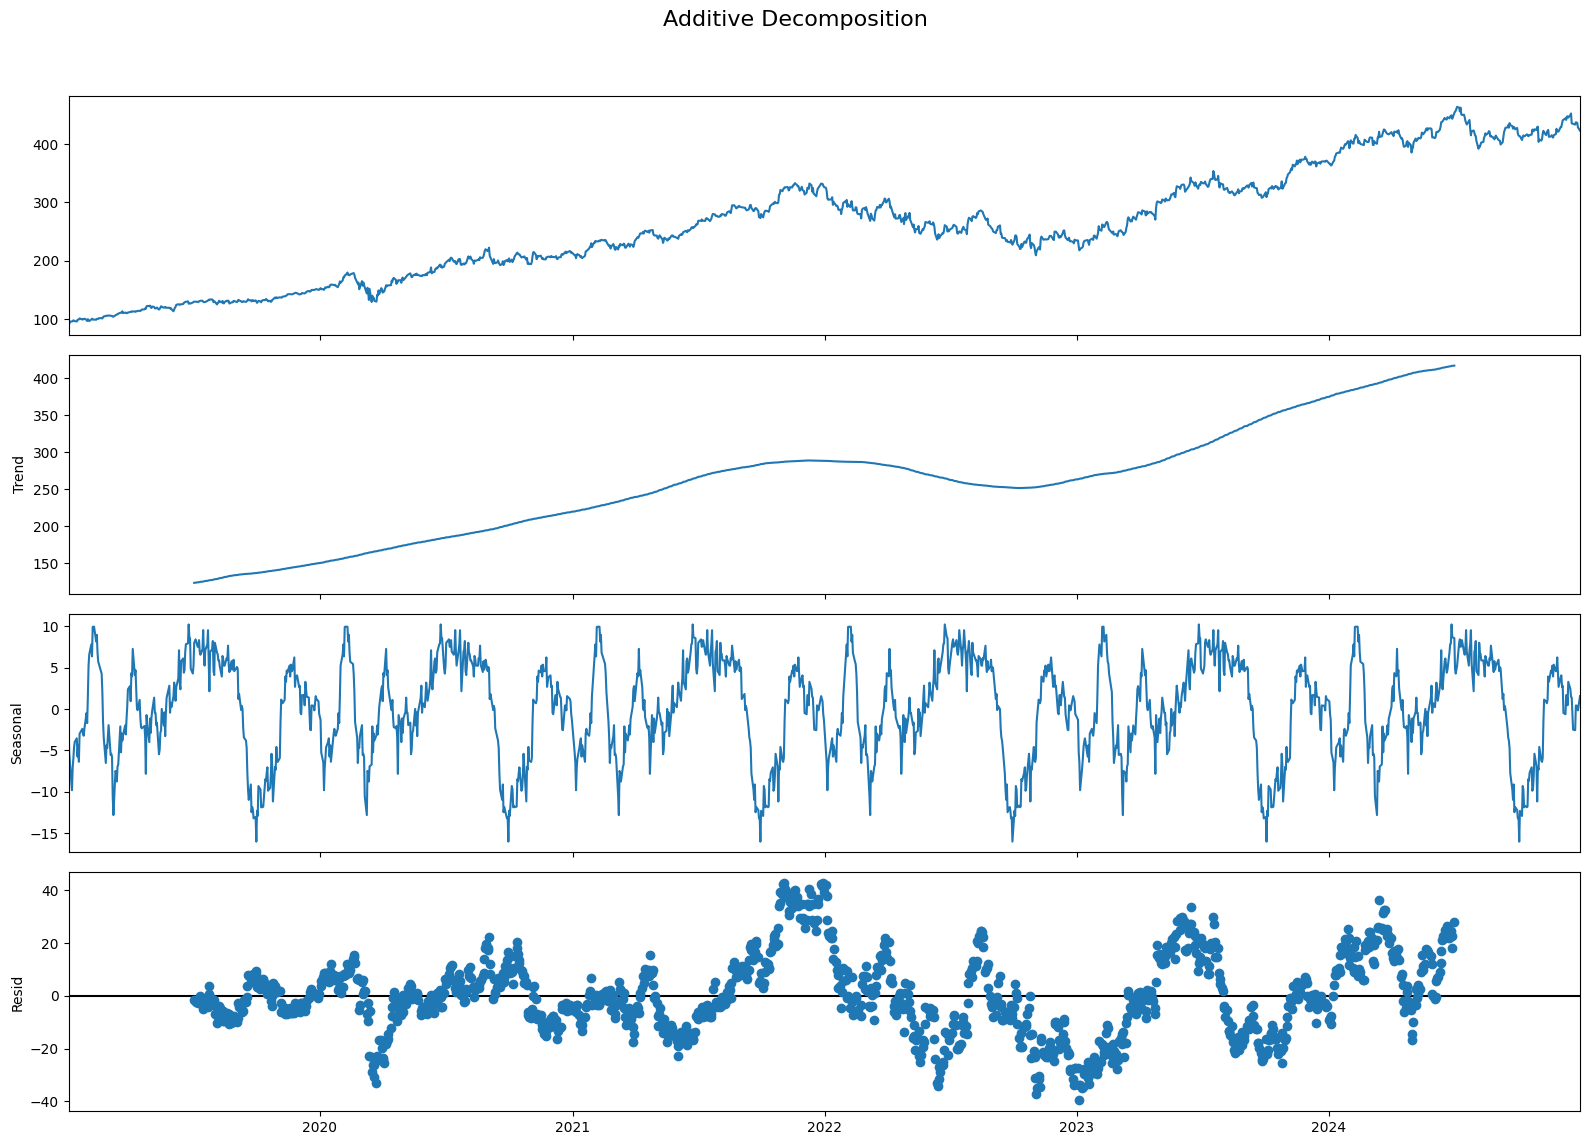

### Detrended Time Series

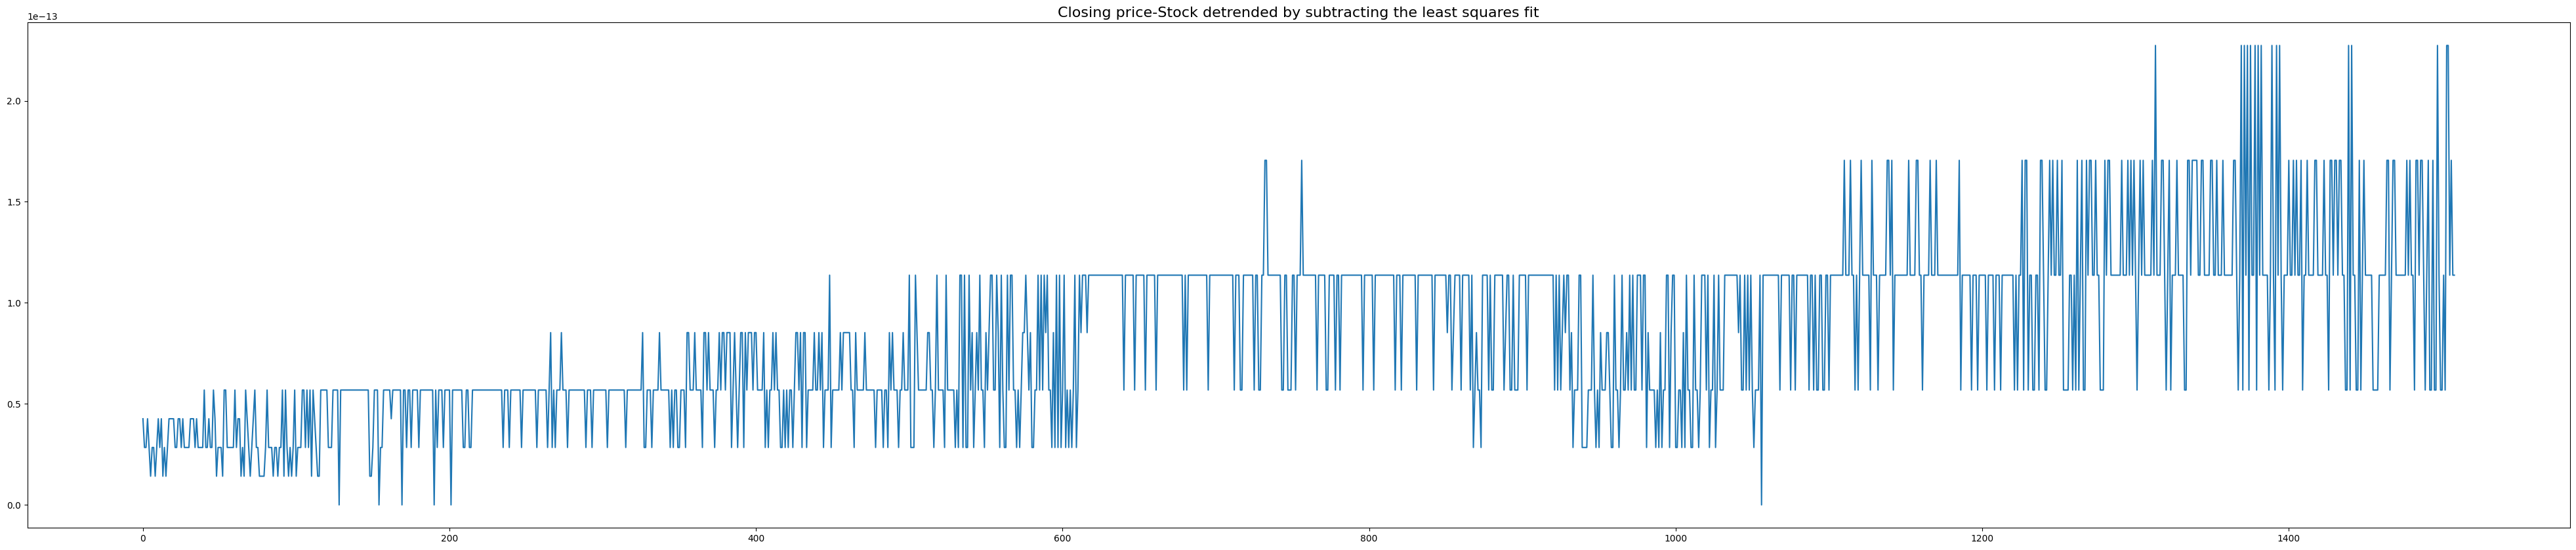

### Deseasonalized Time Series

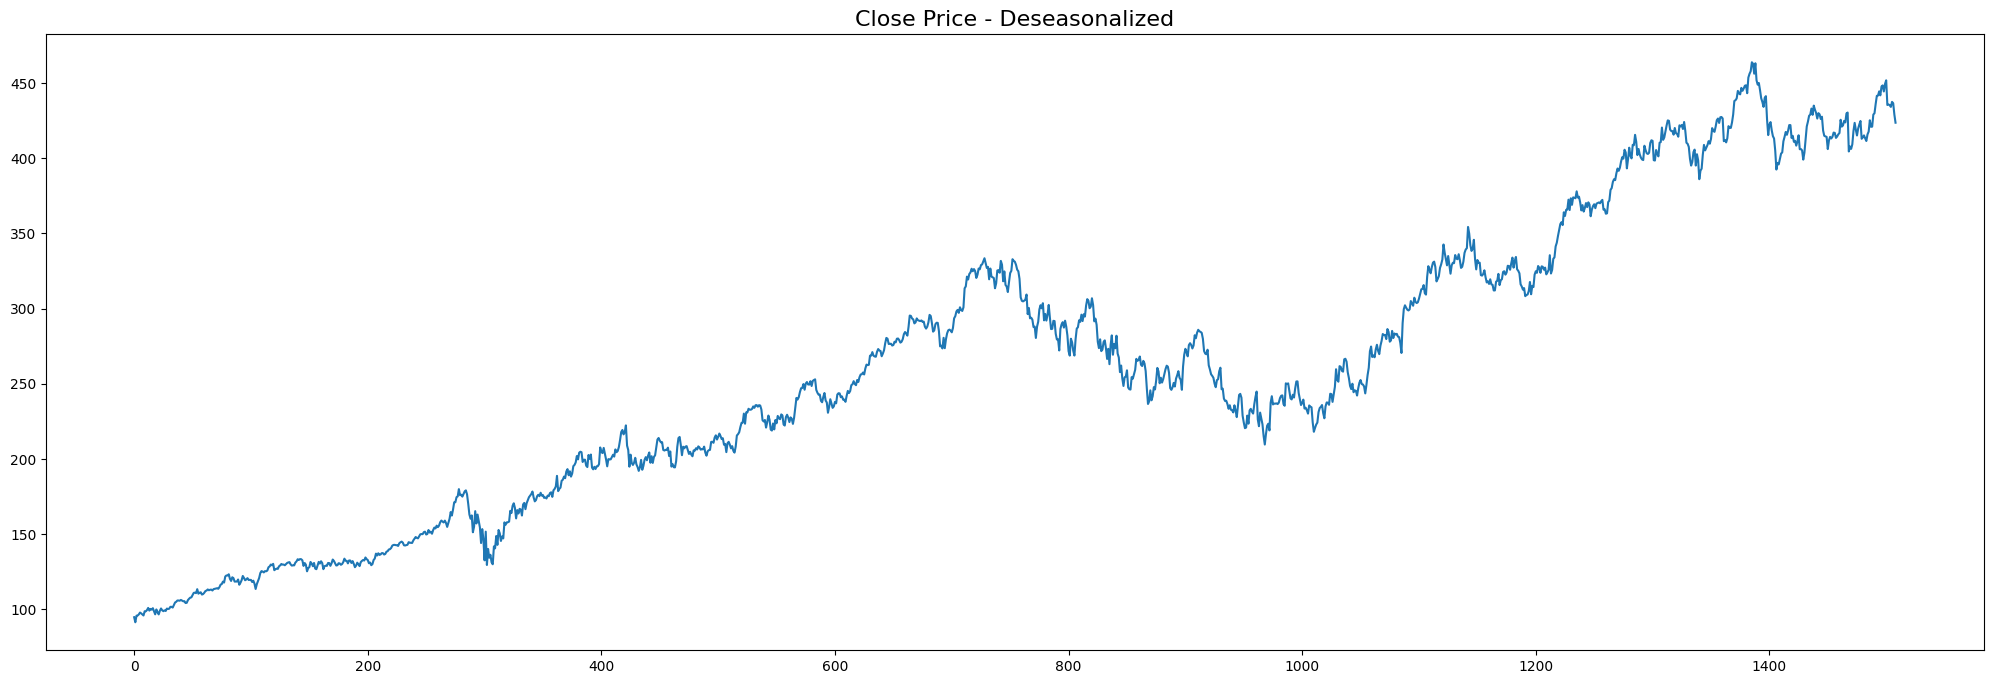

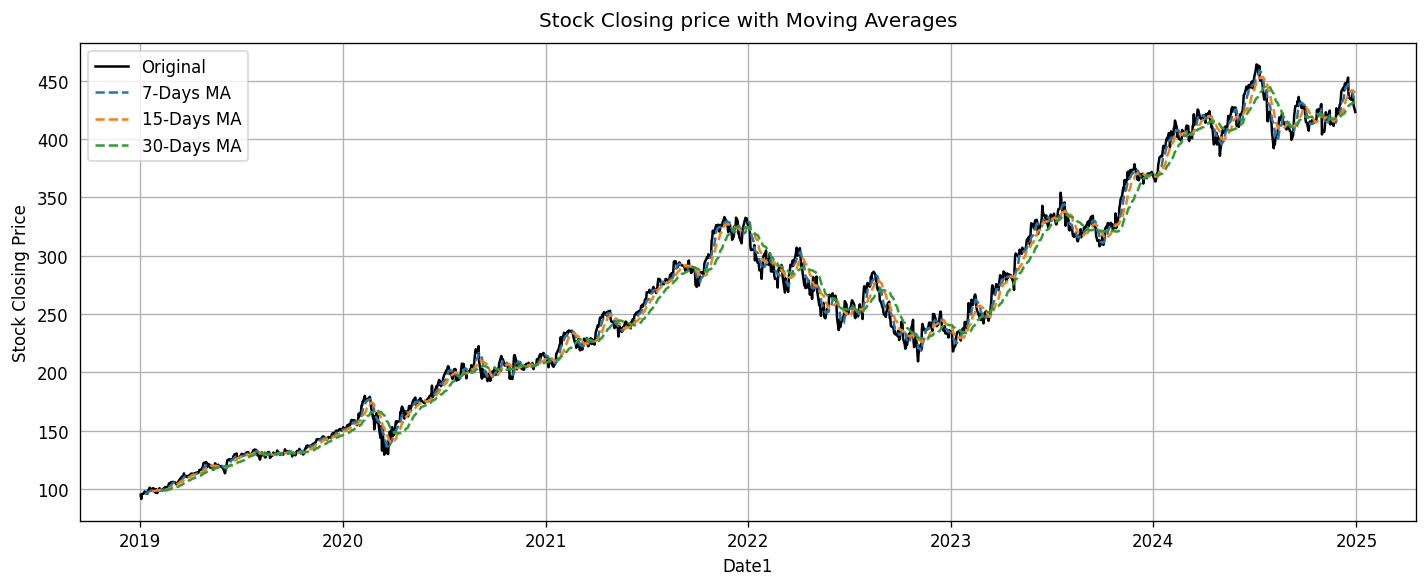

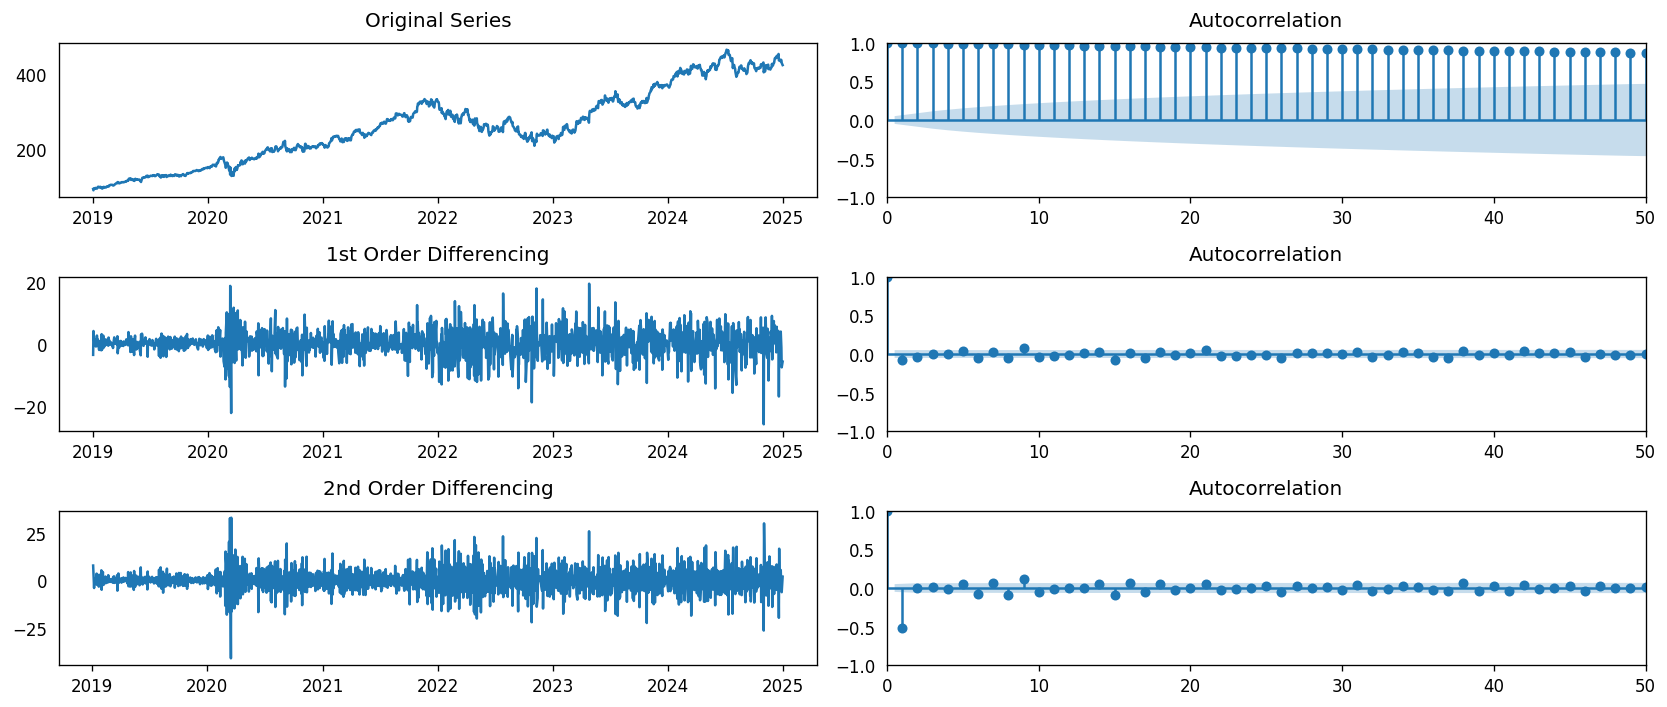

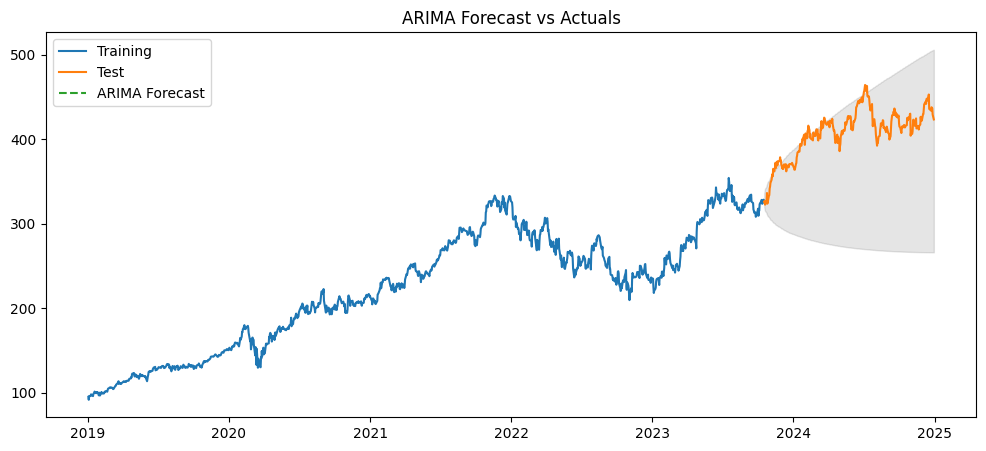

### LSTM Single Step Forecasting - Train vs Val Loss

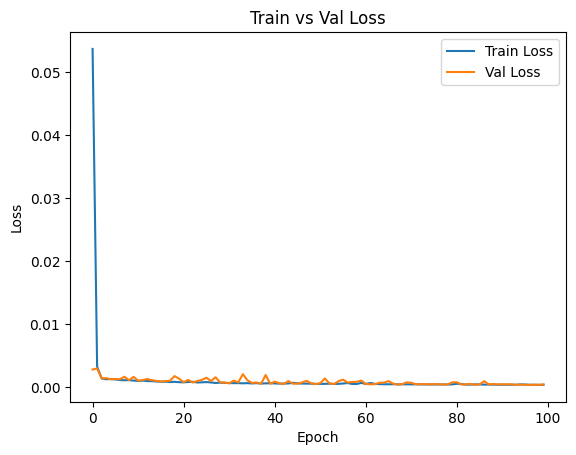

### LSTM Single Step - Forecast vs Actual

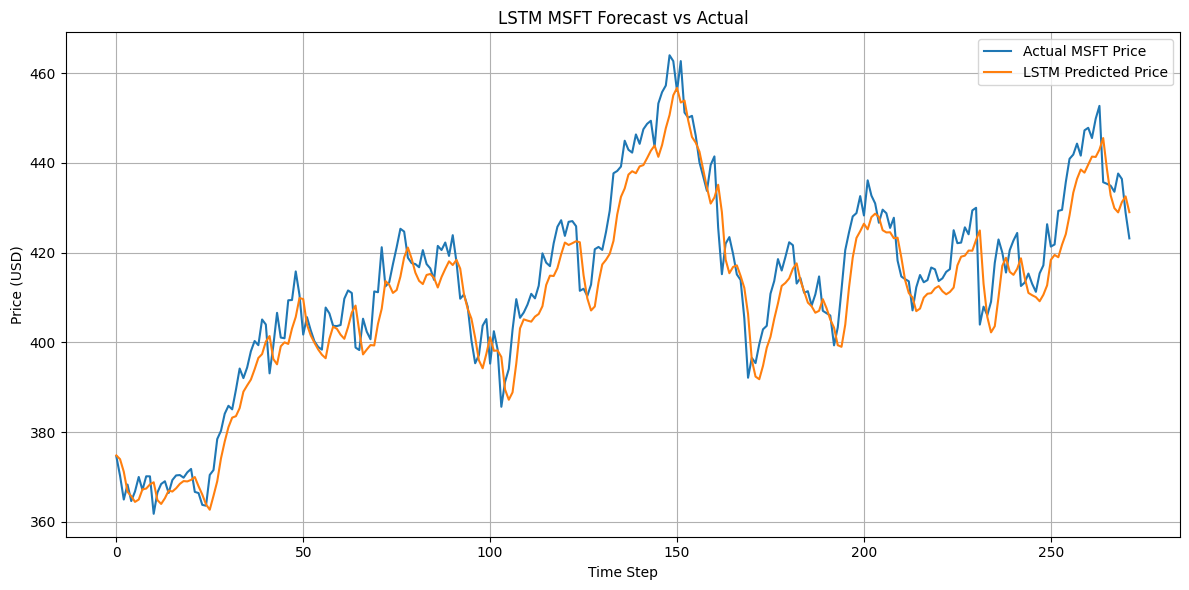

### LSTM Multi Step (7) - Train vs Val Loss

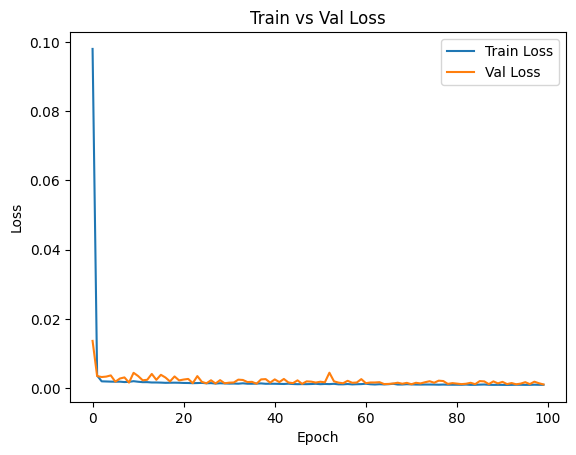

### LSTM Multi Step Forecast

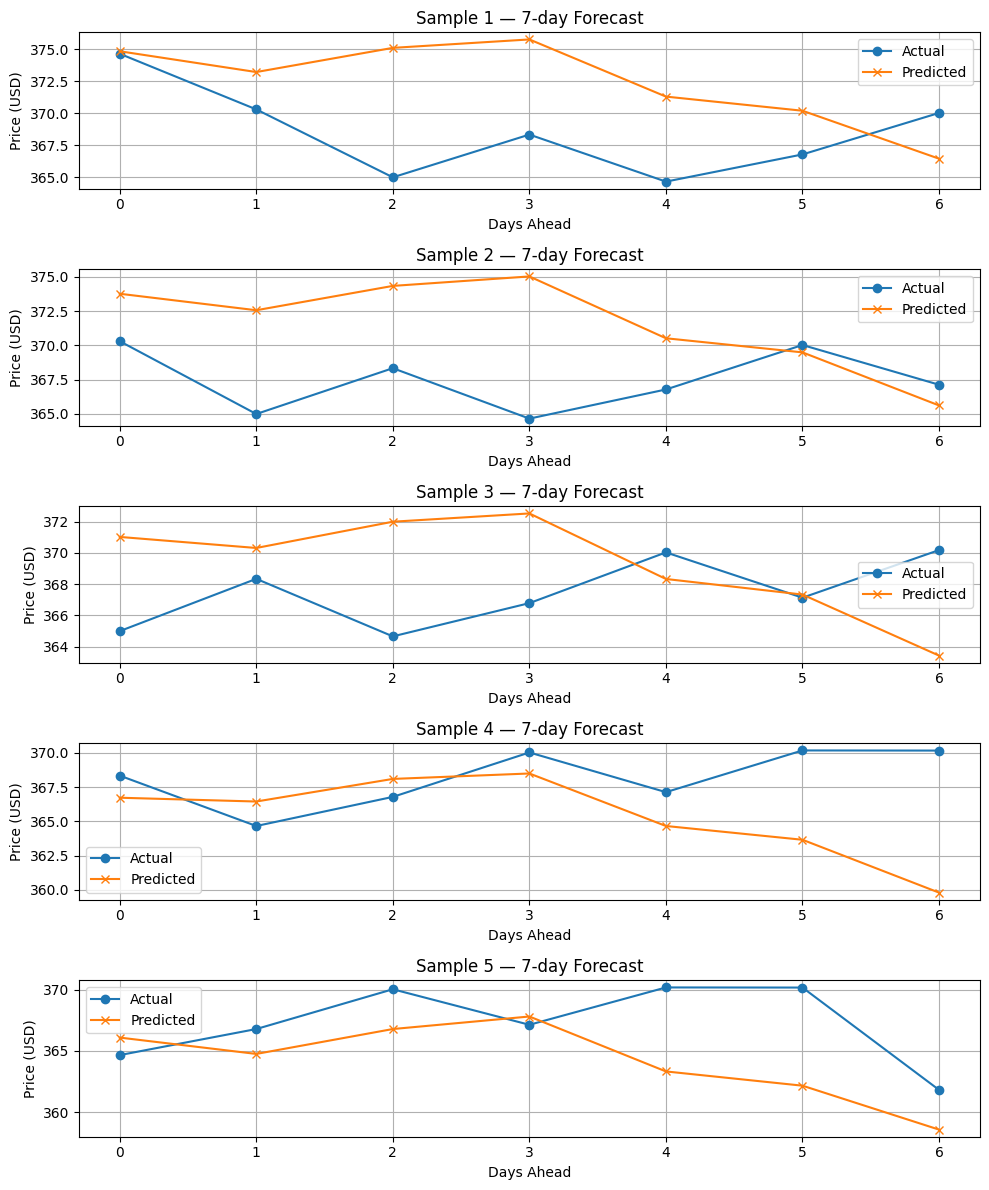

### LSTM Multi Step Forecast - Sliding Window (Walk-Forward)

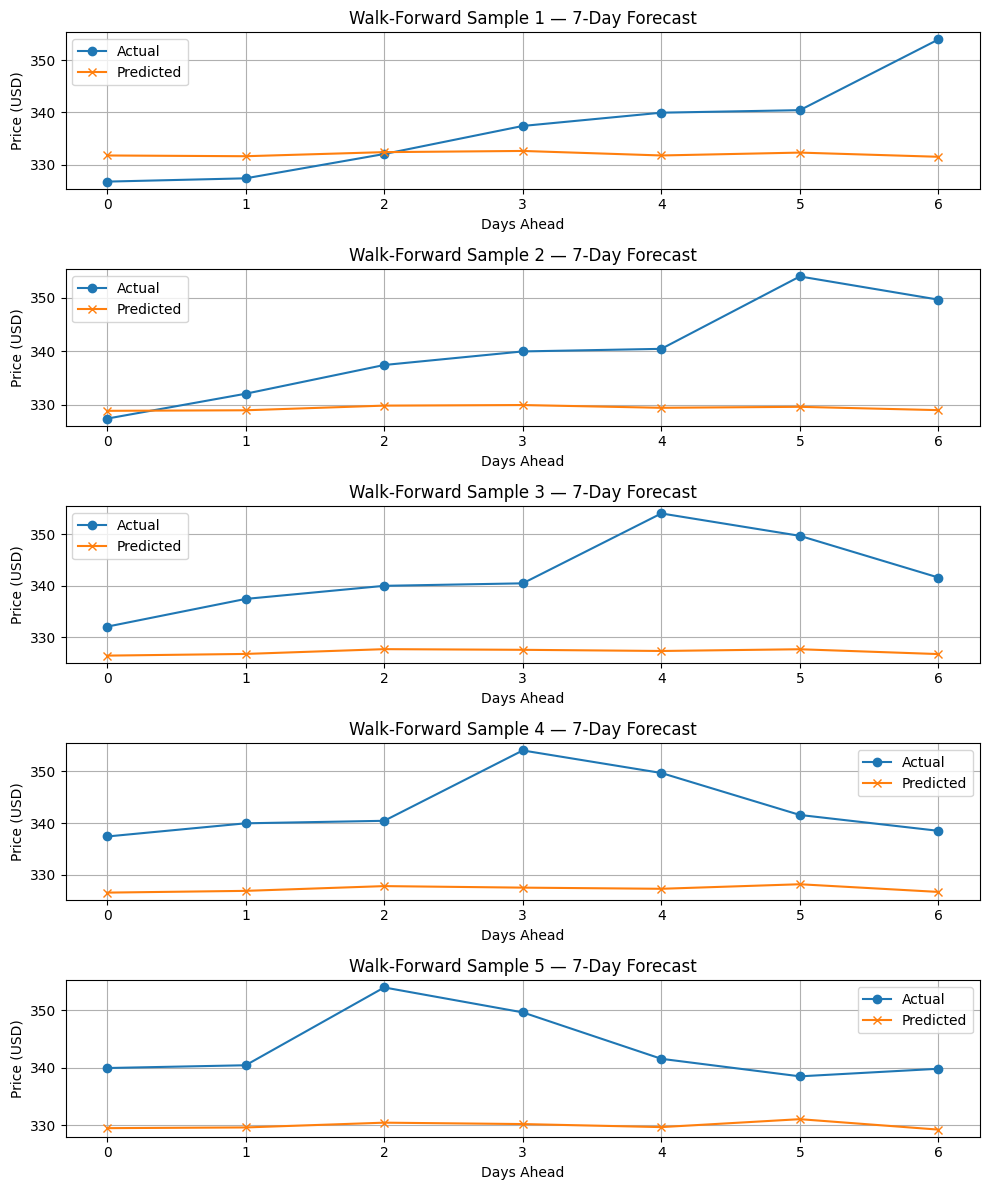

### LSTM Encoder-Decoder input window =30, output window=7

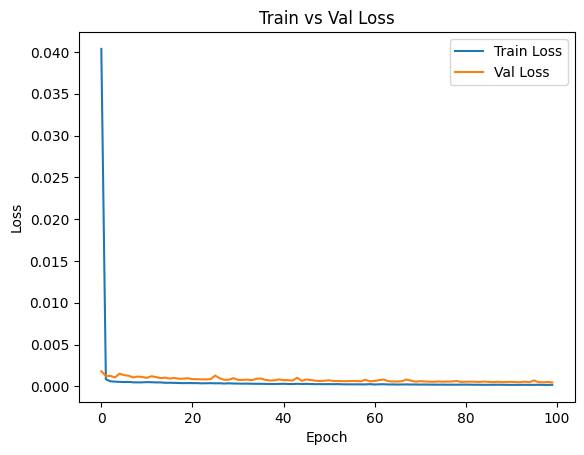

### LSTM Encoder-Decoder input window =30, output window=7 - Forecast

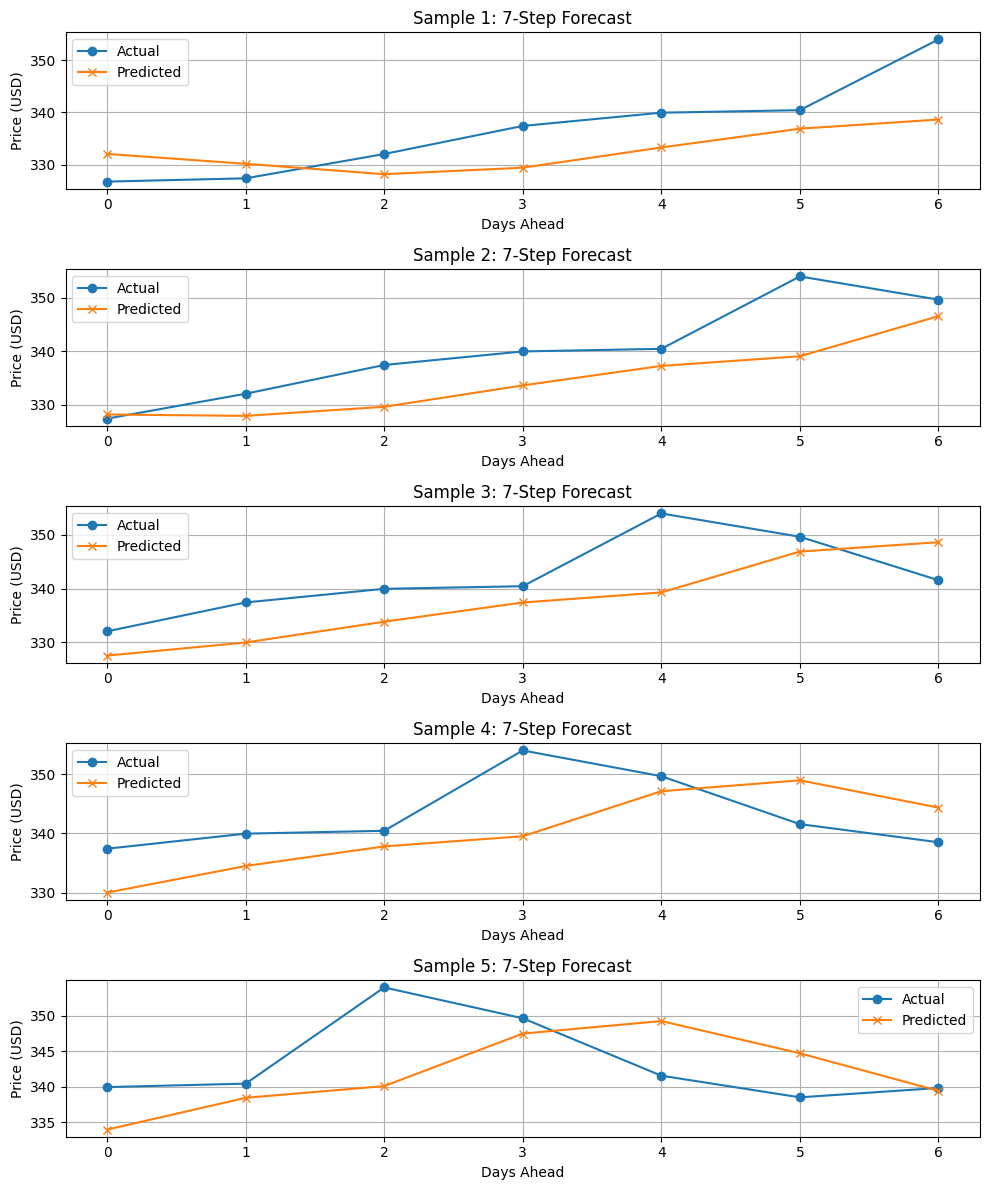

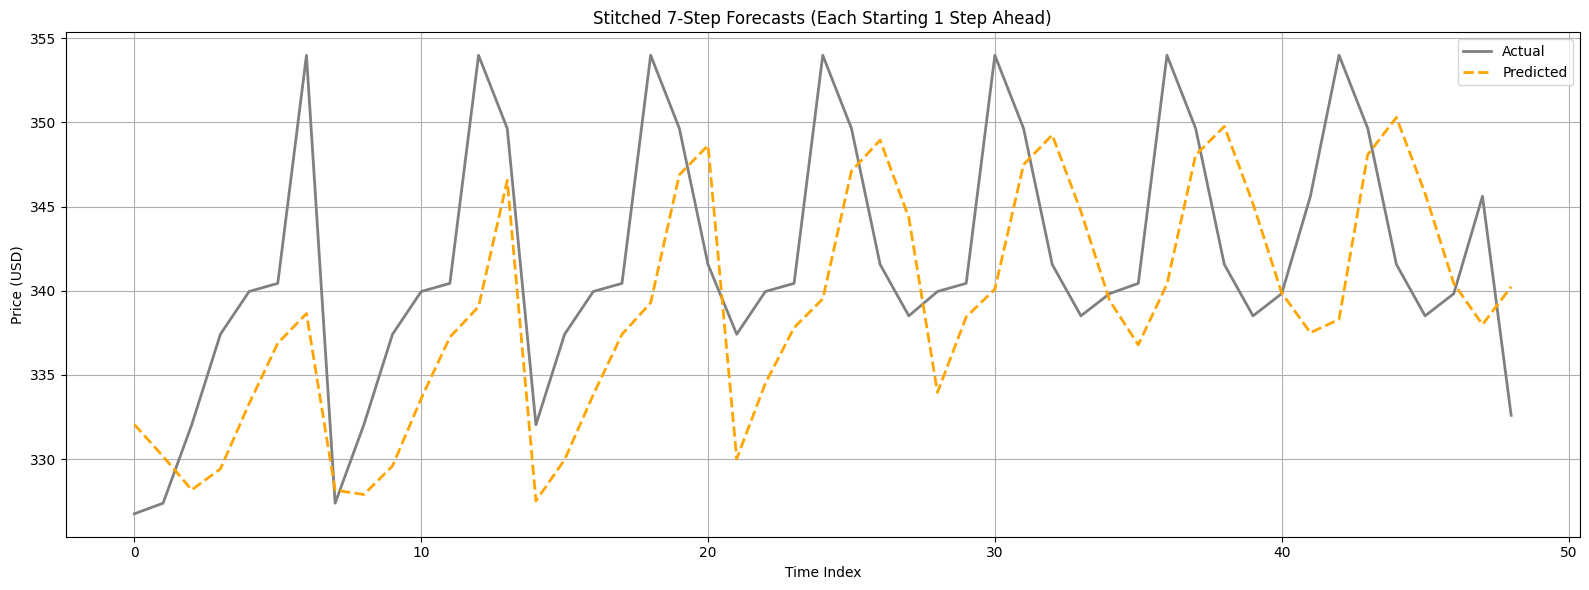

### LSTM Encoder-Decoder input window =30, output window=30

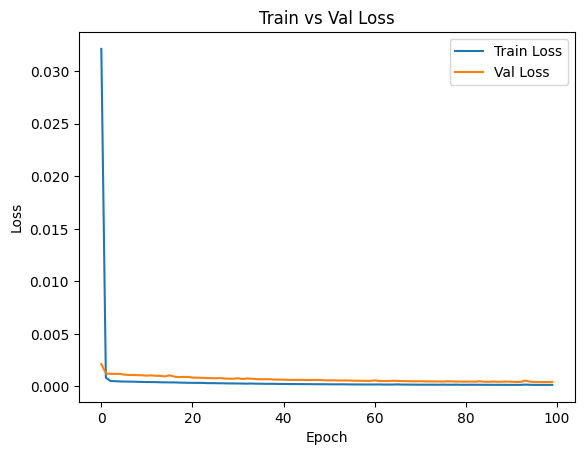

### LSTM Encoder-Decoder input window =30, output window=30 - Forecast

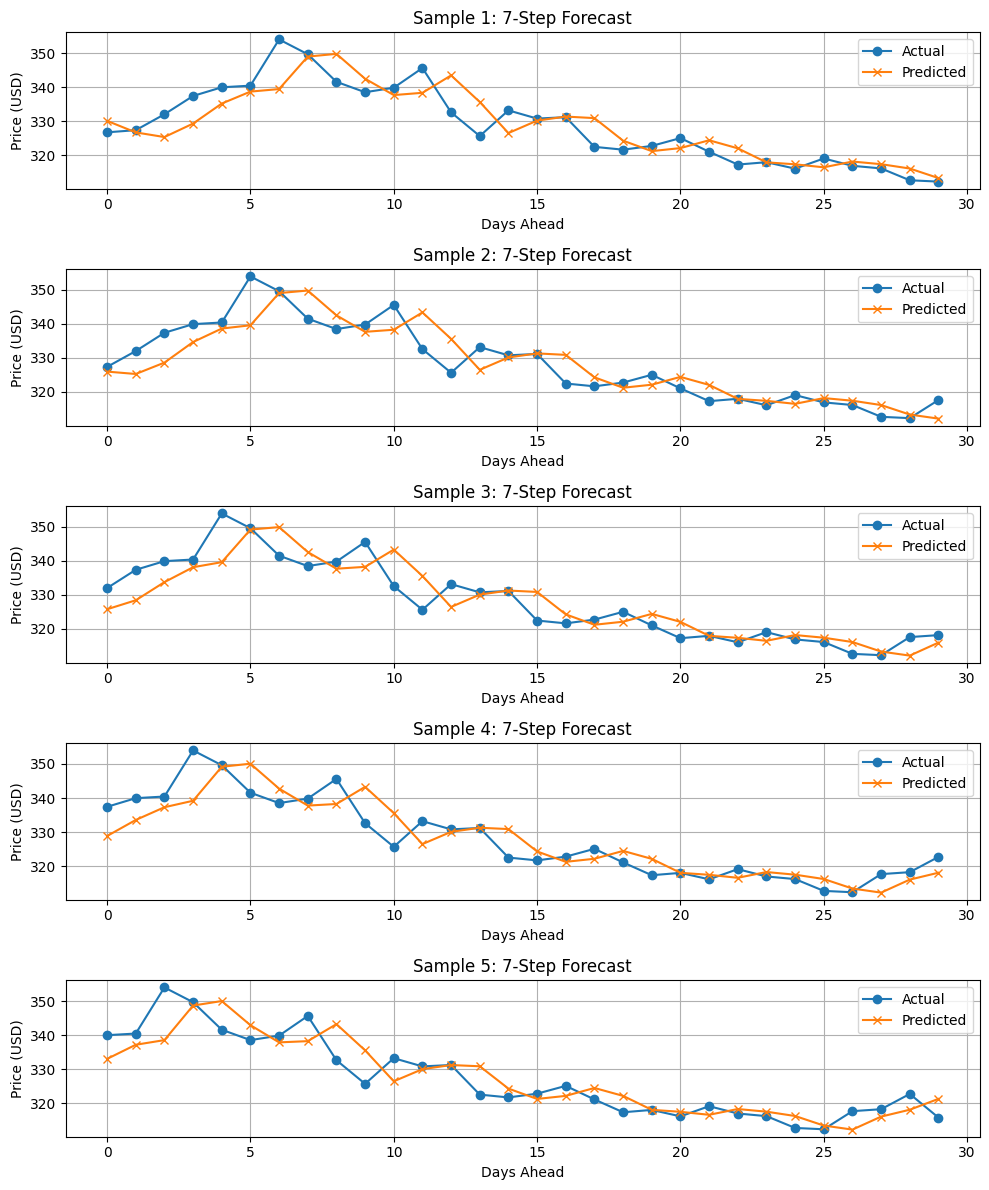

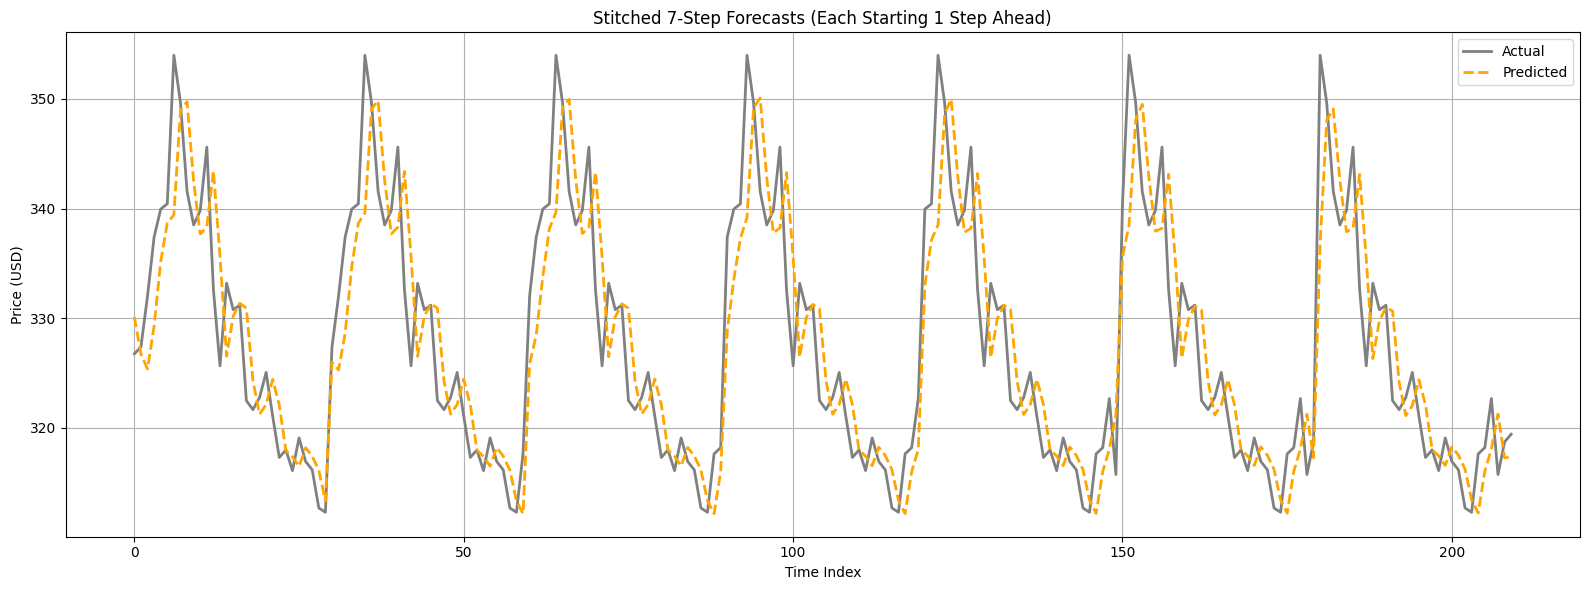